<a href="https://colab.research.google.com/github/changhyun-cho/astrophysics/blob/master/correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A global optical / X-ray correlation from XRBs to AGN

## Import Packages

In [182]:
import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

# Set universal font properties
matplotlib.rcParams[
    "font.family"
] = "serif"  # Font family (e.g., 'serif', 'sans-serif', 'monospace')
matplotlib.rcParams["text.usetex"] = True
dpi = 300  # Set universal DPI for display and saving
plt.rcParams["figure.dpi"] = dpi  # For on-screen display
plt.rcParams["savefig.dpi"] = dpi  # For saving figures

# Size (only for notebook)
plt.rcParams["figure.figsize"] = [10, 10]
colors = ["#0AD2FF", "#2962FF", "#9500FF", "#FF0059", "#FF8C00", "#B4E600", "#0FFFDB"] #matplotlib.cm.Set1(np.linspace(0, 1, 20))

NameError: name 'matplotlib' is not defined

In [183]:
def L_edd(m_BH):
    """
    Calculate the Eddington Luminosity for a black hole using precise constants.

    Parameters:
    mass_solar_units (float): Mass of the black hole in solar masses.

    Returns:
    float: Eddington Luminosity in erg/s.
    """
    # Constants in CGS units
    pi = 3.141592  # Pi
    G = 6.674e-8  # Gravitational constant (cm^3 g^-1 s^-2)
    c = 2.998e10  # Speed of light (cm/s)
    sig_T = 6.6524e-25  # Thomson cross-section (cm^2)
    M_sun = 1.988416e33  # Solar mass in grams
    m_p = 1.67262192e-24

    # Convert black hole mass to grams
    m_BH_grams = m_BH * M_sun

    # Calculate Eddington Luminosity
    L_edd = (4.0 * pi * G * m_BH_grams * m_p * c) / sig_T  # Directly in erg/s

    return L_edd


# Example usage
mass = 10  # Input mass of the black hole in solar masses
L_edd_value = L_edd(mass)
print(f"Eddington Luminosity for a black hole of {mass} solar masses: {L_edd_value:.3e} erg/s")

Eddington Luminosity for a black hole of 10 solar masses: 1.257e+39 erg/s


In [184]:
def r_g(mass):
    
    G = 6.67430e-8  # gravitational constant in cm^3 g^-1 s^-2
    c = 2.99792458e10  # speed of light in cm/s
    M_sun = 1.98847e33  # solar mass in grams

    M = mass * M_sun  # convert mass to grams
    Rg = (2.0 * G * M) / c**2.0
    return Rg

bh_mass = 1  # solar masses
radius_cm = r_g(bh_mass)
print(f"Gravitational radius: {radius_cm:.2e} cm")

Gravitational radius: 2.95e+05 cm


## X-Ray Binaries

### GROJ1655

In [233]:
path_data = "/Users/chcho/GitKraken/astrophysics/agn-xrb/data"

In [234]:
# read the file
groj = pd.read_csv(f"{path_data}/GROJ1655.dat", sep="\t")
groj = groj.dropna()
groj["Target"] = "GROJ1655"

# add lag (in hour)
groj["Lag"] = 19.3  # sec #19.3 from O'Brien 2002, 14.6 from Hynes 1998 (error 2.2)
groj["Lag"] /= 3600.0  # hour



# change units and calculate
groj["L_x"] = 10.0 ** groj["log(Lx_bol)"]
groj["L_opt"] = 10.0 ** groj["log(L_opt)"]
groj["sqrt(L_x) a"] = np.sqrt(groj["L_x"]) * groj["Lag"]

groj["Lag_err"] = 2.2 / 3600.0
groj["X_err"] = np.sqrt(groj["L_x"]) * groj["Lag_err"]




# add inclination
groj["cos_i"] = np.cos(np.radians(70.2))
groj["X_err_cosi"] = np.sqrt(groj["L_x"]) * groj["Lag_err"] * groj["cos_i"]

# add BH mass and its derivatives (Eddington luminosity, gravitational radius)
groj["m_BH"] = 5.4
groj["L_edd"] = L_edd(groj["m_BH"])
groj["r_g"] = r_g(groj["m_BH"])
# extract
groj = groj[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd", "X_err", "X_err_cosi"]]

# make a total data frame
df = groj[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd", "X_err", "X_err_cosi"]]

In [235]:
groj

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd,X_err,X_err_cosi
1,GROJ1655,7.106270e+15,3.426936e+34,1.757008e+36,0.338738,6.804000e+38,8.100412e+14,2.743917e+14
2,GROJ1655,1.857830e+16,3.096749e+34,1.200888e+37,0.338738,6.804000e+38,2.117734e+15,7.173568e+14
3,GROJ1655,2.348740e+16,7.360477e+34,1.919377e+37,0.338738,6.804000e+38,2.677320e+15,9.069098e+14
4,GROJ1655,2.468571e+16,8.296711e+34,2.120223e+37,0.338738,6.804000e+38,2.813915e+15,9.531797e+14
5,GROJ1655,2.824622e+16,4.601569e+34,2.775946e+37,0.338738,6.804000e+38,3.219776e+15,1.090660e+15


### GX339

In [236]:
# read the file
gx = pd.read_csv(f"{path_data}/gx339-4_hard.csv")


gx["Target"] = "GX339"

# add lag (in hour)
gx["Lag"] = 10  # sec from Gandhi 2010 (error +/- 4.0)
gx["Lag"] /= 3600  # hour

# change units and calculate
gx["L_x"] = 10 ** gx["log(Lx_bol)"]
gx["L_opt"] = 10 ** gx["log(L_opt)"]
gx["sqrt(L_x) a"] = np.sqrt(gx["L_x"]) * gx["Lag"]

# add inclination
gx["cos_i"] = np.cos(np.radians(57.5))  # 57.5

# add BH mass and Eddington luminosity
gx["m_BH"] = 5.9
gx["L_edd"] = L_edd(gx["m_BH"])

gx["Lag_err"] = 4.0 / 3600.0
gx["X_err"] = np.sqrt(gx["L_x"]) * gx["Lag_err"]
gx["X_err_cosi"] = np.sqrt(gx["L_x"]) * gx["Lag_err"] * gx["cos_i"]

# extract
gx = gx[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd", "X_err", "X_err_cosi"]]
gx = gx.dropna()
gx
# merge
df = pd.merge(df, gx, how="outer")
# df

In [237]:
gx

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd,X_err,X_err_cosi
0,GX339,2.812194e+15,1.421578e+35,1.024933e+36,0.5373,7.434000e+38,1.124877e+15,6.043962e+14
1,GX339,6.996264e+15,2.889154e+35,6.343623e+36,0.5373,7.434000e+38,2.798506e+15,1.503636e+15
2,GX339,2.848003e+16,5.980957e+35,1.051201e+38,0.5373,7.434000e+38,1.139201e+16,6.120924e+15
3,GX339,3.475615e+16,7.059447e+35,1.565555e+38,0.5373,7.434000e+38,1.390246e+16,7.469785e+15
4,GX339,4.521504e+16,1.108589e+36,2.649542e+38,0.5373,7.434000e+38,1.808602e+16,9.717609e+15
5,GX339,5.648986e+16,1.204400e+36,4.135671e+38,0.5373,7.434000e+38,2.259594e+16,1.214079e+16
6,GX339,5.538148e+16,1.408545e+36,3.974973e+38,0.5373,7.434000e+38,2.215259e+16,1.190258e+16
7,GX339,5.580358e+16,1.370158e+36,4.035796e+38,0.5373,7.434000e+38,2.232143e+16,1.199330e+16
8,GX339,5.603297e+16,1.238143e+36,4.069044e+38,0.5373,7.434000e+38,2.241319e+16,1.204260e+16
9,GX339,5.662756e+16,1.587708e+36,4.155858e+38,0.5373,7.434000e+38,2.265102e+16,1.217039e+16


### XTEJ1118

In [238]:
# read the file
xtej = pd.read_csv(f"{path_data}/XTEJ1118.dat", sep="\t")
xtej["Target"] = "XTEJ1118"

# add lag (in hour)
xtej["Lag"] = 3.45  # sec (error 1.55)
xtej["Lag"] /= 3600  # hour

# change units and calculate
xtej["L_x"] = 10 ** xtej["log(Lx_bol)"]
xtej["L_opt"] = 10 ** xtej["log(L_opt)"]
xtej["sqrt(L_x) a"] = np.sqrt(xtej["L_x"]) * xtej["Lag"]

# extract
xtej = xtej[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]
xtej = xtej.dropna()

# add inclination
xtej["cos_i"] = np.cos(np.radians(75))

# add BH mass and Eddington luminosity
xtej["m_BH"] = 7.3
xtej["L_edd"] = L_edd(xtej["m_BH"])

xtej["Lag_err"] = 1.55 / 3600.0
xtej["X_err"] = np.sqrt(xtej["L_x"]) * xtej["Lag_err"]
xtej["X_err_cosi"] = np.sqrt(xtej["L_x"]) * xtej["Lag_err"] * xtej["cos_i"]


# merge
df = pd.merge(df, xtej, how="outer")
# xtej

In [239]:
xtej

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,m_BH,L_edd,Lag_err,X_err,X_err_cosi
0,XTEJ1118,1.129419e+15,1.560553e+34,1.388919e+36,0.258819,7.3,9.198000e+38,0.000431,5.074200e+14,1.313300e+14
1,XTEJ1118,1.182317e+15,1.819897e+34,1.522070e+36,0.258819,7.3,9.198000e+38,0.000431,5.311858e+14,1.374810e+14
2,XTEJ1118,1.216896e+15,1.684312e+34,1.612405e+36,0.258819,7.3,9.198000e+38,0.000431,5.467216e+14,1.415020e+14
3,XTEJ1118,1.206595e+15,1.493065e+34,1.585221e+36,0.258819,7.3,9.198000e+38,0.000431,5.420934e+14,1.403041e+14
4,XTEJ1118,1.239576e+15,1.619118e+34,1.673066e+36,0.258819,7.3,9.198000e+38,0.000431,5.569109e+14,1.441392e+14
5,XTEJ1118,1.275231e+15,1.869299e+34,1.770698e+36,0.258819,7.3,9.198000e+38,0.000431,5.729299e+14,1.482852e+14
6,XTEJ1118,1.274247e+15,1.626593e+34,1.767966e+36,0.258819,7.3,9.198000e+38,0.000431,5.724877e+14,1.481707e+14
7,XTEJ1118,1.278539e+15,1.695424e+34,1.779898e+36,0.258819,7.3,9.198000e+38,0.000431,5.744163e+14,1.486699e+14
8,XTEJ1118,1.267060e+15,1.685660e+34,1.748080e+36,0.258819,7.3,9.198000e+38,0.000431,5.692589e+14,1.473351e+14
9,XTEJ1118,1.279049e+15,1.334376e+34,1.781316e+36,0.258819,7.3,9.198000e+38,0.000431,5.746451e+14,1.487291e+14


### Swift J1753

In [240]:
# read the file
j1753 = pd.read_csv(f"{path_data}/swift-j1753.csv")
# j1753 = j1753.dropna()

j1753["Target"] = "J1753"

# add lag (in hour)
j1753["Lag"] = 1.0  # sec 1.0 (error 0.5)
j1753["Lag"] /= 3600  # hour

# change units and calculate
j1753["L_x"] = 10 ** j1753["log(Lx_bol)"]
j1753["L_opt"] = 10 ** j1753["log(L_opt)"]
j1753["sqrt(L_x) a"] = np.sqrt(j1753["L_x"]) * j1753["Lag"]

# extract
j1753 = j1753[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]
j1753

# add inclination
j1753["cos_i"] = np.cos(np.radians(79))

# add BH mass and Eddington luminosity
j1753["m_BH"] = 8.8
j1753["L_edd"] = L_edd(j1753["m_BH"])

j1753["Lag_err"] = 0.5 / 3600.0
j1753["X_err"] = np.sqrt(j1753["L_x"]) * j1753["Lag_err"]
j1753["X_err_cosi"] = np.sqrt(j1753["L_x"]) * j1753["Lag_err"] * j1753["cos_i"]

# merge
df = pd.merge(df, j1753, how="outer")
# j1753

In [241]:
j1753

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,m_BH,L_edd,Lag_err,X_err,X_err_cosi
0,J1753,5.978588e+14,7.840989e+33,4.632360e+36,0.190809,8.8,1.108800e+39,0.000139,2.989294e+14,5.703842e+13
1,J1753,1.351221e+15,9.592065e+33,2.366235e+37,0.190809,8.8,1.108800e+39,0.000139,6.756106e+14,1.289126e+14
2,J1753,1.021388e+15,9.788930e+33,1.352030e+37,0.190809,8.8,1.108800e+39,0.000139,5.106939e+14,9.744500e+13
3,J1753,6.630840e+14,8.221621e+33,5.698258e+36,0.190809,8.8,1.108800e+39,0.000139,3.315420e+14,6.326120e+13
4,J1753,7.233961e+14,9.227027e+33,6.781993e+36,0.190809,8.8,1.108800e+39,0.000139,3.616981e+14,6.901524e+13
5,J1753,5.190140e+14,8.878046e+33,3.491107e+36,0.190809,8.8,1.108800e+39,0.000139,2.595070e+14,4.951627e+13


### MAXI J1820+070

In [242]:
import numpy as np
import pandas as pd

# Example Eddington luminosity function
def L_edd(m_BH):
    return 1.26e38 * m_BH  # erg/s

# -------------------------
# CREATE DATAFRAME
# -------------------------
j1820 = pd.DataFrame({
    "Target": ["MAXI J1820"] * 3,
    "log_L_x": [37.71953872, 38.19665997, 38.19665997],
    "log_L_opt": [34.89257259, 35.12382942, 35.25678942],
})

# -------------------------
# ADD LAG (seconds → hours) error 1.6
# -------------------------
j1820["Lag"] = 4.1 / 3600 

# -------------------------
# CONVERT LUMINOSITIES
# -------------------------
j1820["L_x"] = 10 ** j1820["log_L_x"]
j1820["L_opt"] = 10 ** j1820["log_L_opt"]

# -------------------------
# COMPUTE sqrt(Lx) × lag
# -------------------------
j1820["sqrt(L_x) a"] = np.sqrt(j1820["L_x"]) * j1820["Lag"]

# -------------------------
# ADD GEOMETRY & BH INFO
# -------------------------
j1820["cos_i"] = np.cos(np.radians(73.5))
j1820["m_BH"] = 7.04
j1820["L_edd"] = L_edd(j1820["m_BH"])


j1820["Lag_err"] = 1.6 / 3600.0
j1820["X_err"] = np.sqrt(j1820["L_x"]) * j1820["Lag_err"]
j1820["X_err_cosi"] = np.sqrt(j1820["L_x"]) * j1820["Lag_err"] * j1820["cos_i"]

# -------------------------
# SHOW RESULT
# -------------------------
j1820 = j1820[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd", "X_err", "X_err_cosi"]]
j1820


,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd,X_err,X_err_cosi
0,MAXI J1820,8.246140e+15,7.808589e+34,5.242503e+37,0.284015,8.870400e+38,3.218006e+15,9.139631e+14
1,MAXI J1820,1.428273e+16,1.329932e+35,1.572751e+38,0.284015,8.870400e+38,5.573750e+15,1.583030e+15
2,MAXI J1820,1.428273e+16,1.806298e+35,1.572751e+38,0.284015,8.870400e+38,5.573750e+15,1.583030e+15


In [243]:
# merge
df = pd.merge(df, j1820, how="outer")


In [304]:
j1820

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd,X_err,X_err_cosi
0,MAXI J1820,8.246140e+15,7.808589e+34,5.242503e+37,0.284015,8.870400e+38,3.218006e+15,9.139631e+14
1,MAXI J1820,1.428273e+16,1.329932e+35,1.572751e+38,0.284015,8.870400e+38,5.573750e+15,1.583030e+15
2,MAXI J1820,1.428273e+16,1.806298e+35,1.572751e+38,0.284015,8.870400e+38,5.573750e+15,1.583030e+15


## AGN

### Temporary part (Import data directly from Excel)

In [244]:
custom_header = ["time", "flux"]

In [245]:
mr2251_opt = pd.read_csv(f"{path_data}/mr2251-178_optical", header=None, names=custom_header)
mr2251_opt["flux"] *= 1.0e-11
mr2251_opt["flux"] *= 3.33564095e04  # see the other file for unit conversion
# mr2251_opt["flux"] *= 5326# # To cancel A, but is that really right? (Jy)
mr2251_opt["flux"] *= 1000  # To make mJy
mr2251_opt  # mJy

,time,flux
0,3949.689,0.000107
1,3959.544,0.000108
2,3962.656,0.000110
3,3966.805,0.000112
4,3969.917,0.000116
5,3974.066,0.000118
6,3980.290,0.000118
7,3986.515,0.000118
8,3993.776,0.000121
9,4002.075,0.000122


In [246]:
mr2251_xray = pd.read_csv(f"{path_data}/mr2251-178_x-ray", header=None, names=custom_header)
# mr2251_xray["flux"] *= 3.33564095E+04 # see the other file for unit conversion
mr2251_xray["flux"] *= 1.0e-11
mr2251_xray

,time,flux
0,3943.582,3.111000e-11
1,3952.381,3.833000e-11
2,3967.909,4.028000e-11
3,3979.296,4.639000e-11
4,3996.894,5.000000e-11
...,...,...
58,4433.747,5.111000e-11
59,4439.959,4.667000e-11
60,4442.029,4.194000e-11
61,4450.311,3.917000e-11


In [247]:
# read AGN data
agn = pd.read_csv(f"{path_data}/agn_data.csv")
agn["Target"] = agn["targets"]
# agn["Lag"] = agn["Lags(hour)"]

# change units and calculate
agn["L_x"] = 10 ** agn["log(Lx_bol)"]
agn["L_opt"] = 10 ** agn["log(L_opt)"]


#groj["Lag_err"] = 2.2 / 3600.0
#groj["X_err"] = np.sqrt(groj["L_x"]) * groj["Lag_err"]


# agn["sqrt(L_x) a"] = np.sqrt(agn["L_x"]) * agn["Lag"]

# extract
# agn = agn[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]

# merge
# df = pd.merge(df, agn, how="outer")
# df
agn

,targets,log(Lx_bol),log(L_opt),Target,L_x,L_opt
0,NGC2617,43.756590,42.667831,NGC2617,5.709398e+43,4.654049e+42
1,NGC2617,43.663107,42.666249,NGC2617,4.603705e+43,4.637122e+42
2,NGC2617,43.672488,42.663000,NGC2617,4.704222e+43,4.602566e+42
3,NGC2617,43.668760,42.653456,NGC2617,4.664015e+43,4.502524e+42
4,NGC2617,43.748876,42.663829,NGC2617,5.608881e+43,4.611361e+42
...,...,...,...,...,...,...
415,NGC4151,43.449250,42.101555,NGC4151,2.813521e+43,1.263441e+42
416,NGC4151,43.455923,42.087750,NGC4151,2.857087e+43,1.223913e+42
417,NGC4151,43.483077,42.124498,NGC4151,3.041428e+43,1.331982e+42
418,NGC4151,43.506782,42.122711,NGC4151,3.212049e+43,1.326512e+42


### NGC4593

In [250]:
n4593 = {
    "log(Lx_bol)": [43.46477309, 43.0967963],
    "log(L_opt)": [41.90607624, 41.60504625],
    "Target": ["NGC4593", "NGC4593"],
    "Lag": [0.907 * 24, 0.907 * 24],
}

# Create a DataFrame
n4593 = pd.DataFrame(n4593)

# change units and calculate
n4593["L_x"] = 10 ** n4593["log(Lx_bol)"]
n4593["L_opt"] = 10 ** n4593["log(L_opt)"]
n4593["sqrt(L_x) a"] = np.sqrt(n4593["L_x"]) * n4593["Lag"]

# add inclination
n4593["cos_i"] = np.cos(np.radians(20))

# add BH mass and Eddington luminosity
n4593["m_BH"] = 7.63e6
n4593["L_edd"] = L_edd(n4593["m_BH"])


n4593["Lag_err"] = 0.41 * 24
xerr_n4593 = np.sqrt(n4593["L_x"]) * n4593["Lag_err"]
xerr_n4593_cosi = np.sqrt(n4593["L_x"]) * n4593["Lag_err"] * n4593["cos_i"]

# extract
n4593 = n4593[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd"]]
# n4395
# merge
df = pd.merge(df, n4593, how="outer")
# df

In [251]:
n4593

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd
0,NGC4593,1.175452e+23,8.055198e+41,2.915903e+43,0.939693,9.613800e+44
1,NGC4593,7.695143e+22,4.027599e+41,1.249673e+43,0.939693,9.613800e+44


### NGC4151

In [256]:
n4151 = agn[agn["Target"] == "NGC4151"]

# change units and calculate
n4151["Lag"] = (0.34 + 0.96) * 24  # 0.34
n4151["sqrt(L_x) a"] = np.sqrt(n4151["L_x"]) * n4151["Lag"]

# add inclination
n4151["cos_i"] = np.cos(np.radians(45))

# add BH mass and Eddington luminosity
n4151["m_BH"] = 5.4e7
n4151["L_edd"] = L_edd(n4151["m_BH"])


n4151["Lag_err"] = 0.48 * 24
n4151["Lag_err-"] = 0.47 * 24
n4151["X_err"] = np.sqrt(n4151["L_x"]) * n4151["Lag_err"]

# asymmetric x-errors (DO NOT put these in the DataFrame)
xerr_n4151 = np.vstack([
    np.sqrt(n4151["L_x"].values) * n4151["Lag_err-"].values,  # lower
    np.sqrt(n4151["L_x"].values) * n4151["Lag_err"].values   # upper
])

xerr_n4151_cosi = np.vstack([
    np.sqrt(n4151["L_x"].values) * n4151["Lag_err-"].values * n4151["cos_i"].values,  # lower
    np.sqrt(n4151["L_x"].values) * n4151["Lag_err"].values * n4151["cos_i"].values   # upper
])

n4151 = n4151[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd"]]
# n4395
# merge
df = pd.merge(df, n4151, how="outer")
# df

/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/2585764102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n4151["Lag"] = (0.34 + 0.96) * 24  # 0.34
/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/2585764102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n4151["sqrt(L_x) a"] = np.sqrt(n4151["L_x"]) * n4151["Lag"]
/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/2585764102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [255]:
n4151

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd
118,NGC4151,1.953186e+23,1.308391e+42,3.919023e+43,0.707107,6.804000e+45
119,NGC4151,2.100993e+23,1.254582e+42,4.534609e+43,0.707107,6.804000e+45
120,NGC4151,2.356237e+23,1.384648e+42,5.703334e+43,0.707107,6.804000e+45
121,NGC4151,2.220724e+23,1.283269e+42,5.066173e+43,0.707107,6.804000e+45
122,NGC4151,1.991913e+23,1.426525e+42,4.075977e+43,0.707107,6.804000e+45
...,...,...,...,...,...,...
415,NGC4151,1.654930e+23,1.263441e+42,2.813521e+43,0.707107,6.804000e+45
416,NGC4151,1.667694e+23,1.223913e+42,2.857087e+43,0.707107,6.804000e+45
417,NGC4151,1.720653e+23,1.331982e+42,3.041428e+43,0.707107,6.804000e+45
418,NGC4151,1.768258e+23,1.326512e+42,3.212049e+43,0.707107,6.804000e+45


### NGC3516

In [260]:
n3516 = {
    "log(Lx_bol)": [
        42.75427141,
        43.26615477,
        43.40344395,
        43.50439394,
        43.29313826,
        42.59154411,
        42.39524947,
    ],
    "log(L_opt)": [
        41.22413275,
        41.37055074,
        41.59063864,
        41.70835932,
        41.57812735,
        40.97698508,
        40.56992657,
    ],
    "Target": [
        "NGC3516",
        "NGC3516",
        "NGC3516",
        "NGC3516",
        "NGC3516",
        "NGC3516",
        "NGC3516",
    ],
    "Lag": [2.6 * 24, 2.6 * 24, 2.6 * 24, 2.6 * 24, 2.6 * 24, 2.6 * 24, 2.6 * 24],
}


# Create a DataFrame
n3516 = pd.DataFrame(n3516)

# change units and calculate
n3516["L_x"] = 10 ** n3516["log(Lx_bol)"]
n3516["L_opt"] = 10 ** n3516["log(L_opt)"]
n3516["sqrt(L_x) a"] = np.sqrt(n3516["L_x"]) * n3516["Lag"]

# add inclination
n3516["cos_i"] = np.cos(np.radians(38))  # cos(38)=0.78, cos(27)=0.89

# add BH mass and Eddington luminosity
n3516["m_BH"] = 1.91e6
n3516["L_edd"] = L_edd(n3516["m_BH"])

n3516["Lag_err"] = 0.91 * 24
n3516["Lag_err-"] = 0.78 * 24
#n3516["X_err"] = np.sqrt(n3516["L_x"]) * n3516["Lag_err"]

xerr_n3516 = np.vstack([
    np.sqrt(n3516["L_x"].values) * n3516["Lag_err-"].values,  # lower
    np.sqrt(n3516["L_x"].values) * n3516["Lag_err"].values   # upper
])

xerr_n3516_cosi = np.vstack([
    np.sqrt(n3516["L_x"].values) * n3516["Lag_err-"].values * n3516["cos_i"].values,  # lower
    np.sqrt(n3516["L_x"].values) * n3516["Lag_err"].values * n3516["cos_i"].values   # upper
])

# extract
n3516 = n3516[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd"]]
# n4395
# merge
df = pd.merge(df, n3516, how="outer")
# df)

In [261]:
xerr_n3516_cosi

array([[3.51539146e+22, 6.33746208e+22, 7.42266676e+22, 8.33748295e+22,
        6.53743101e+22, 2.91480861e+22, 2.32521290e+22],
       [4.10129004e+22, 7.39370576e+22, 8.65977789e+22, 9.72706344e+22,
        7.62700284e+22, 3.40061004e+22, 2.71274838e+22]])

### NGC4051

In [262]:
n4051 = {
    "log(Lx_bol)": [42.55961056],
    "log(L_opt)": [41.40543954],
    "Target": ["NGC4051"],
    "Lag": [1.2 * 24],
}

# Create a DataFrame
n4051 = pd.DataFrame(n4051)

# change units and calculate
n4051["L_x"] = 10 ** n4051["log(Lx_bol)"]
n4051["L_opt"] = 10 ** n4051["log(L_opt)"]
n4051["sqrt(L_x) a"] = np.sqrt(n4051["L_x"]) * n4051["Lag"]

# add inclination
n4051["cos_i"] = np.cos(np.radians(78))

# add BH mass and Eddington luminosity
n4051["m_BH"] = 1.73e6
n4051["L_edd"] = L_edd(n4051["m_BH"])

n4051["Lag_err"] = 1.0 * 24
n4051["Lag_err-"] = 0.3 * 24

# asymmetric x-errors (DO NOT put these in the DataFrame)
xerr_n4051 = np.vstack([
    np.sqrt(n4051["L_x"].values) * n4051["Lag_err-"].values,  # lower
    np.sqrt(n4051["L_x"].values) * n4051["Lag_err"].values   # upper
])

xerr_n4051_cosi = np.vstack([
    np.sqrt(n4051["L_x"].values) * n4051["Lag_err-"].values * n4051["cos_i"].values,  # lower
    np.sqrt(n4051["L_x"].values) * n4051["Lag_err"].values * n4051["cos_i"].values   # upper
])



# extract
n4051 = n4051[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd"]]
# n4395
# merge
df = pd.merge(df, n4051, how="outer")
# df

In [263]:
n4051

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd
0,NGC4051,5.485267e+22,2.543546e+41,3.627526e+42,0.207912,2.179800e+44


### NGC2617

In [264]:
n2617 = agn[agn["Target"] == "NGC2617"]

# change units and calculate
n2617["Lag"] = 2.47 * 24
# n2617["L_x"] = 10 ** n2617["log(Lx_bol)"]
# n2617["L_opt"] = 10 ** n2617["log(L_opt)"]
n2617["sqrt(L_x) a"] = np.sqrt(n2617["L_x"]) * n2617["Lag"]

# add inclination
n2617["cos_i"] = np.cos(np.radians(43))


# add BH mass and Eddington luminosity
n2617["m_BH"] = 3.24e7
n2617["L_edd"] = L_edd(n2617["m_BH"])

n2617["Lag_err"] = 0.88 * 24
n2617["Lag_err-"] = 0.81 * 24

# asymmetric x-errors (DO NOT put these in the DataFrame)
xerr_n2617 = np.vstack([
    np.sqrt(n2617["L_x"].values) * n2617["Lag_err-"].values,  # lower
    np.sqrt(n2617["L_x"].values) * n2617["Lag_err"].values   # upper
])

xerr_n2617_cosi = np.vstack([
    np.sqrt(n2617["L_x"].values) * n2617["Lag_err-"].values * n2617["cos_i"].values,  # lower
    np.sqrt(n2617["L_x"].values) * n2617["Lag_err"].values * n2617["cos_i"].values   # upper
])

n2617 = n2617[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd"]]


# merge
df = pd.merge(df, n2617, how="outer")
# df

/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/903349523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n2617["Lag"] = 2.47 * 24
/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/903349523.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n2617["sqrt(L_x) a"] = np.sqrt(n2617["L_x"]) * n2617["Lag"]
/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/903349523.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [266]:
n2617

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd
0,NGC2617,4.479230e+23,4.654049e+42,5.709398e+43,0.731354,4.082400e+45
1,NGC2617,4.022184e+23,4.637122e+42,4.603705e+43,0.731354,4.082400e+45
2,NGC2617,4.065857e+23,4.602566e+42,4.704222e+43,0.731354,4.082400e+45
3,NGC2617,4.048444e+23,4.502524e+42,4.664015e+43,0.731354,4.082400e+45
4,NGC2617,4.439625e+23,4.611361e+42,5.608881e+43,0.731354,4.082400e+45
...,...,...,...,...,...,...
113,NGC2617,4.100461e+23,3.899430e+42,4.784636e+43,0.731354,4.082400e+45
114,NGC2617,3.986901e+23,3.900533e+42,4.523291e+43,0.731354,4.082400e+45
115,NGC2617,4.022184e+23,4.008665e+42,4.603705e+43,0.731354,4.082400e+45
116,NGC2617,3.595586e+23,4.087594e+42,3.678943e+43,0.731354,4.082400e+45


### NGC 4395

In [267]:
n4395 = {
    "log(Lx_bol)": [
        41.71714338,
        41.32503292,
        40.84791166,
    ],  # [41.59438157, 41.2022711, 40.72514985],
    "log(L_opt)": [
        39.5380524,
        39.30273827,
        38.96186472,
    ],  # [39.52690065, 39.22587066, 38.82793065],
    "Target": ["NGC4395", "NGC4395", "NGC4395"],
    "Lag": [0.21888889, 0.21888889, 0.21888889],  # 788 sec to hours
}


# Create a DataFrame
n4395 = pd.DataFrame(n4395)

# change units and calculate
n4395["L_x"] = 10 ** n4395["log(Lx_bol)"]
n4395["L_opt"] = 10 ** n4395["log(L_opt)"]
n4395["sqrt(L_x) a"] = np.sqrt(n4395["L_x"]) * n4395["Lag"]

# add inclination
n4395["cos_i"] = np.cos(np.radians(37))  # 45 37

# add BH mass and Eddington luminosity
n4395["m_BH"] = 3.6e5
n4395["L_edd"] = L_edd(n4395["m_BH"])

n4395["Lag_err"] = 44 / 3600.0
n4395["Lag_err-"] = 54 / 3600.0

# asymmetric x-errors (DO NOT put these in the DataFrame)
xerr_n4395 = np.vstack([
    np.sqrt(n4395["L_x"].values) * n4395["Lag_err-"].values,  # lower
    np.sqrt(n4395["L_x"].values) * n4395["Lag_err"].values   # upper
])

xerr_n4395_cosi = np.vstack([
    np.sqrt(n4395["L_x"].values) * n4395["Lag_err-"].values * n4395["cos_i"].values,  # lower
    np.sqrt(n4395["L_x"].values) * n4395["Lag_err"].values * n4395["cos_i"].values   # upper
])


# extract
n4395 = n4395[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd"]]
# n4395
# merge
df = pd.merge(df, n4395, how="outer")
#df

In [268]:
n4395

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd
0,NGC4395,1.580503e+20,3.451854e+39,5.213668e+41,0.798636,4.536000e+43
1,NGC4395,1.006329e+20,2.007882e+39,2.113649e+41,0.798636,4.536000e+43
2,NGC4395,5.810046e+19,9.159351e+38,7.045497e+40,0.798636,4.536000e+43


### NGC 6814

In [269]:
n6814 = {
    "log(Lx_bol)": [43.06633308, 42.6983563, 42.22123504],
    "log(L_opt)": [41.18588092, 40.99174683, 40.78288835],
    "Target": ["NGC6814", "NGC6814", "NGC6814"],
    "Lag": [1.9 * 24, 1.9 * 24, 1.9 * 24],
}


# Create a DataFrame
n6814 = pd.DataFrame(n6814)

# change units and calculate
n6814["L_x"] = 10 ** n6814["log(Lx_bol)"]
n6814["L_opt"] = 10 ** n6814["log(L_opt)"]
n6814["sqrt(L_x) a"] = np.sqrt(n6814["L_x"]) * n6814["Lag"]

# add inclination
n6814["cos_i"] = np.cos(np.radians(50))

# add BH mass and Eddington luminosity
n6814["m_BH"] = 1.85e7
n6814["L_edd"] = L_edd(n6814["m_BH"])

n6814["Lag_err"] = 1.1 * 24
n6814["Lag_err-"] = 1.2 * 24

# asymmetric x-errors (DO NOT put these in the DataFrame)
xerr_n6814 = np.vstack([
    np.sqrt(n6814["L_x"].values) * n6814["Lag_err-"].values,  # lower
    np.sqrt(n6814["L_x"].values) * n6814["Lag_err"].values   # upper
])

xerr_n6814_cosi = np.vstack([
    np.sqrt(n6814["L_x"].values) * n6814["Lag_err-"].values * n6814["cos_i"].values,  # lower
    np.sqrt(n6814["L_x"].values) * n6814["Lag_err"].values * n6814["cos_i"].values   # upper
])

# extract
n6814 = n6814[["Target", "sqrt(L_x) a", "L_opt", "L_x", "cos_i", "L_edd"]]

# merge
df = pd.merge(df, n6814, how="outer")
# df

In [270]:
n6814

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd
0,NGC6814,1.556436e+23,1.534196e+41,1.165019e+43,0.642788,2.331000e+45
1,NGC6814,1.018927e+23,9.811758e+40,4.992939e+42,0.642788,2.331000e+45
2,NGC6814,5.882777e+22,6.065804e+40,1.664313e+42,0.642788,2.331000e+45


### NGC5548 (Removing Host Galaxy Contribution)

#### 1. Download data from the archive



In [271]:
df

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd,X_err,X_err_cosi,m_BH,Lag_err
0,GROJ1655,7.106270e+15,3.426936e+34,1.757008e+36,0.338738,6.804000e+38,8.100412e+14,2.743917e+14,NaN,NaN
1,GROJ1655,1.857830e+16,3.096749e+34,1.200888e+37,0.338738,6.804000e+38,2.117734e+15,7.173568e+14,NaN,NaN
2,GROJ1655,2.348740e+16,7.360477e+34,1.919377e+37,0.338738,6.804000e+38,2.677320e+15,9.069098e+14,NaN,NaN
3,GROJ1655,2.468571e+16,8.296711e+34,2.120223e+37,0.338738,6.804000e+38,2.813915e+15,9.531797e+14,NaN,NaN
4,GROJ1655,2.824622e+16,4.601569e+34,2.775946e+37,0.338738,6.804000e+38,3.219776e+15,1.090660e+15,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
547,XTEJ1118,1.327738e+15,1.604275e+34,1.919516e+36,0.258819,9.198000e+38,5.965201e+14,1.543908e+14,7.3,0.000431
548,XTEJ1118,1.332586e+15,1.717888e+34,1.933557e+36,0.258819,9.198000e+38,5.986979e+14,1.549544e+14,7.3,0.000431
549,XTEJ1118,1.356434e+15,1.695424e+34,2.003384e+36,0.258819,9.198000e+38,6.094124e+14,1.577275e+14,7.3,0.000431
550,XTEJ1118,1.374335e+15,1.532071e+34,2.056610e+36,0.258819,9.198000e+38,6.174547e+14,1.598090e+14,7.3,0.000431


## Plots and Fittings

In [272]:
# Example data
x = np.log10(df["sqrt(L_x) a"])
y = np.log10(df["L_opt"])
# y_err = np.array([0.1, 0.1, 0.1, 0.1, 0.1])  # Standard deviations (errors) of y


# Define a model function (e.g., a linear function)
def model(x, a, b):
    return 1.000040304102203 * x + 19.205922827856142


# 1.000040304102203, 19.205922827856142
# Perform curve fitting
popt, pcov = curve_fit(model, x, y)

# Calculate the chi-squared value
y_err = 1.0
chi_squared = np.sum(((y - model(x, *popt)) / y_err) ** 2)

# Calculate the degrees of freedom
dof = len(x) - len(popt)

# Calculate the reduced chi-squared value
reduced_chi_squared = chi_squared / dof
print("Reduced Chi-Squared:", reduced_chi_squared)

Reduced Chi-Squared: 0.15628515113267827


/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/199898958.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(model, x, y)


In [273]:
# Example data
x = np.log10(df["sqrt(L_x) a"])
y = np.log10(df["L_opt"])


# Define a model function (e.g., a linear function)
def model(x, a, b):
    return 1.000040304102203 * x + 19.205922827856142


# Perform curve fitting
popt, pcov = curve_fit(model, x, y)

# Calculate the expected values from the model
expected_y = model(x, *popt)

# Calculate the residuals
residuals = y - expected_y

# Estimate the standard deviation of the residuals
estimated_error = np.std(residuals)

# Use the estimated standard deviation as the error for each data point
y_err = np.full_like(y, estimated_error)

# Calculate the chi-squared value using the estimated errors
chi_squared = np.sum(((y - expected_y) / y_err) ** 2)

# Calculate the degrees of freedom
dof = len(x) - len(popt)

# Calculate the reduced chi-squared value
reduced_chi_squared = chi_squared / dof

print("Chi-Squared:", chi_squared)
print("Reduced Chi-Squared:", reduced_chi_squared)
print("Estimated Error:", estimated_error)

Chi-Squared: 1400.137388694866
Reduced Chi-Squared: 2.545704343081575
Estimated Error: 0.24777351206813503


/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/1393354786.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(model, x, y)


In [274]:
# Example data
x = np.log10(df["sqrt(L_x) a"])
y = np.log10(df["L_opt"])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the expected values from the linear model
expected_y = slope * x + intercept

# Calculate the residuals
residuals = y - expected_y

# Estimate the standard deviation of the residuals
estimated_error = np.std(
    residuals, ddof=2
)  # Use ddof=2 to account for the two parameters (slope and intercept)

# Use the estimated standard deviation as the error for each data point
y_err = np.full_like(y, estimated_error)

# Calculate the chi-squared value using the estimated errors
chi_squared = np.sum(((y - expected_y) / y_err) ** 2)

# Calculate the degrees of freedom
dof = (
    len(x) - 2
)  # Number of data points minus number of parameters (slope and intercept)

# Calculate the reduced chi-squared value
reduced_chi_squared = chi_squared / dof

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("Chi-Squared:", chi_squared)
print("Reduced Chi-Squared:", reduced_chi_squared)
print("Estimated Error:", estimated_error)

Slope: 0.9551983721966729
Intercept: 19.874781671283717
R-value: 0.9978802913251726
Chi-Squared: 549.9999999999998
Reduced Chi-Squared: 0.9999999999999996
Estimated Error: 0.20145561441356258


In [275]:
# Example data
x = np.log10(df["sqrt(L_x) a"] * df["cos_i"])
y = np.log10(df["L_opt"])


# Define a model function (e.g., a linear function)
def model(x, a, b):
    return 0.9626054008148883 * x + 20.206523644512476


# Perform curve fitting
popt, pcov = curve_fit(model, x, y)

# Calculate the expected values from the model
expected_y = model(x, *popt)

# Calculate the residuals
residuals = y - expected_y

# Estimate the standard deviation of the residuals
estimated_error = np.std(residuals)

# Use the estimated standard deviation as the error for each data point
y_err = np.full_like(y, estimated_error)

# Calculate the chi-squared value using the estimated errors
chi_squared = np.sum(((y - expected_y) / y_err) ** 2)

# Calculate the degrees of freedom
dof = len(x) - len(popt)

# Calculate the reduced chi-squared value
reduced_chi_squared = chi_squared / dof

print("Chi-Squared:", chi_squared)
print("Reduced Chi-Squared:", reduced_chi_squared)
print("Estimated Error:", estimated_error)

Chi-Squared: 1393.7586192701642
Reduced Chi-Squared: 2.5341065804912075
Estimated Error: 0.23474013132985522


/var/folders/9q/lkjfsz1s60x18g5s7xh0xwzw0000gn/T/ipykernel_6763/3100420864.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(model, x, y)


In [276]:
# Example data
x = np.log10(df["sqrt(L_x) a"] * df["cos_i"])
y = np.log10(df["L_opt"])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the expected values from the linear model
expected_y = slope * x + intercept

# Calculate the residuals
residuals = y - expected_y

# Estimate the standard deviation of the residuals
estimated_error = np.std(
    residuals, ddof=2
)  # Use ddof=2 to account for the two parameters (slope and intercept)

# Use the estimated standard deviation as the error for each data point
y_err = np.full_like(y, estimated_error)

# Calculate the chi-squared value using the estimated errors
chi_squared = np.sum(((y - expected_y) / y_err) ** 2)

# Calculate the degrees of freedom
dof = (
    len(x) - 2
)  # Number of data points minus number of parameters (slope and intercept)

# Calculate the reduced chi-squared value
reduced_chi_squared = chi_squared / dof

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("Chi-Squared:", chi_squared)
print("Reduced Chi-Squared:", reduced_chi_squared)
print("Estimated Error:", estimated_error)

Slope: 0.9183094869820231
Intercept: 20.871405048433903
R-value: 0.9982724523729777
Chi-Squared: 549.9999999999999
Reduced Chi-Squared: 0.9999999999999998
Estimated Error: 0.18188585284606107


In [277]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

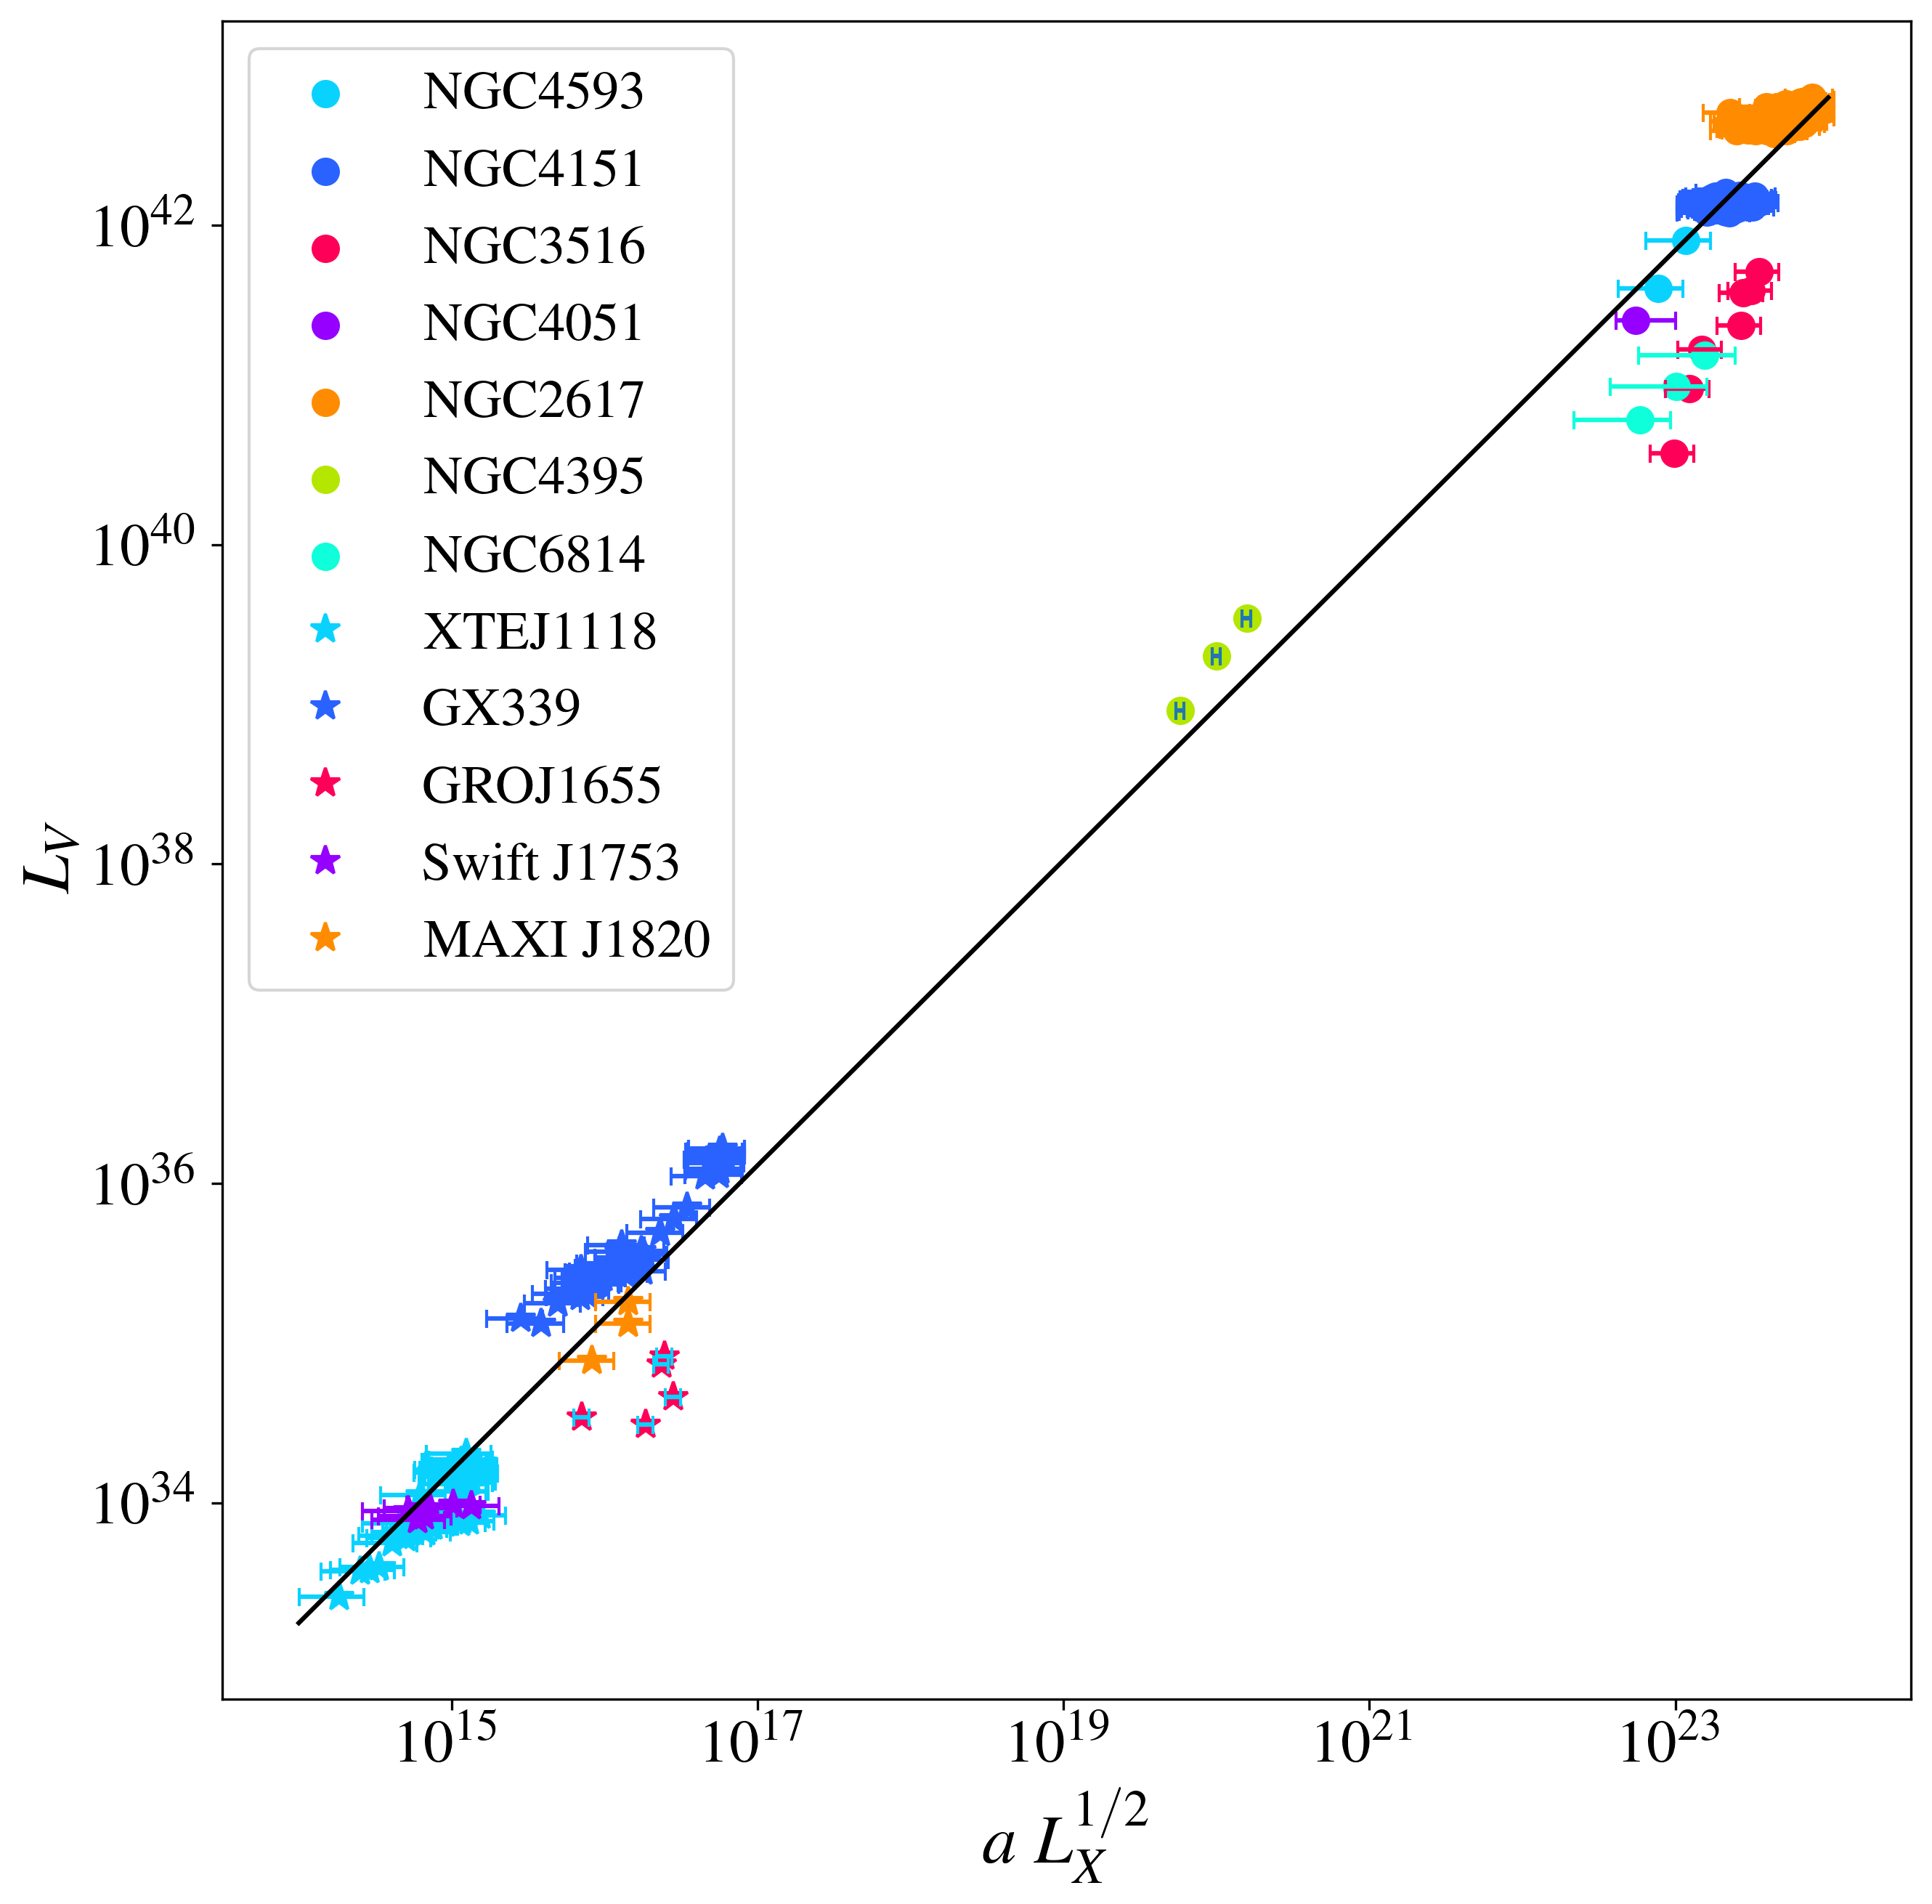

(np.float64(0.9551983721966719), np.float64(19.874781671283706))

In [283]:
# AGN
plt.scatter(n4593["sqrt(L_x) a"], n4593["L_opt"], s=70, color=colors[0], label="NGC4593")
plt.errorbar(n4593["sqrt(L_x) a"], n4593["L_opt"], xerr=xerr_n4593, color=colors[0], linestyle='none', capsize=3)

plt.scatter(n4151["sqrt(L_x) a"], n4151["L_opt"], s=70, color=colors[1], label="NGC4151")
plt.errorbar(n4151["sqrt(L_x) a"], n4151["L_opt"], xerr=xerr_n4151, color=colors[1], linestyle='none', capsize=3)

plt.scatter(n3516["sqrt(L_x) a"], n3516["L_opt"], s=70, color=colors[3], label="NGC3516")
plt.errorbar(n3516["sqrt(L_x) a"], n3516["L_opt"], xerr=xerr_n3516, color=colors[3], linestyle='none', capsize=3)

plt.scatter(n4051["sqrt(L_x) a"], n4051["L_opt"], s=70, color=colors[2], label="NGC4051")
plt.errorbar(n4051["sqrt(L_x) a"], n4051["L_opt"], xerr=xerr_n4051, color=colors[2], linestyle='none', capsize=3)

plt.scatter(n2617["sqrt(L_x) a"], n2617["L_opt"], s=70, color=colors[4], label="NGC2617")
plt.errorbar(n2617["sqrt(L_x) a"], n2617["L_opt"], xerr=xerr_n2617, color=colors[4], linestyle='none', capsize=3)

plt.scatter(n4395["sqrt(L_x) a"], n4395["L_opt"], s=70, color=colors[5], label="NGC4395")
plt.errorbar(n4395["sqrt(L_x) a"], n4395["L_opt"], xerr=xerr_n4395,     linestyle='none', capsize=3)

plt.scatter(n6814["sqrt(L_x) a"], n6814["L_opt"], s=70, color=colors[6], label="NGC6814")
plt.errorbar(n6814["sqrt(L_x) a"], n6814["L_opt"], xerr=xerr_n6814,color=colors[6],     linestyle='none', capsize=3)

# XRBs
plt.plot(xtej["sqrt(L_x) a"], xtej["L_opt"],  "*",  color=colors[0], markersize=10, label="XTEJ1118")
plt.errorbar(xtej["sqrt(L_x) a"], xtej["L_opt"], xerr=xtej["X_err"] ,color=colors[0],     linestyle='none', capsize=3)

plt.plot(gx["sqrt(L_x) a"], gx["L_opt"], "*", color=colors[1], markersize=10, label="GX339")
plt.errorbar(gx["sqrt(L_x) a"], gx["L_opt"], xerr=gx["X_err"] ,color=colors[1],     linestyle='none', capsize=3)

plt.plot(groj["sqrt(L_x) a"], groj["L_opt"], "*", color=colors[3], markersize=10, label="GROJ1655")
plt.errorbar(groj["sqrt(L_x) a"], groj["L_opt"], xerr=groj["X_err"] ,color=colors[0],     linestyle='none', capsize=3)

plt.plot(j1753["sqrt(L_x) a"], j1753["L_opt"], "*", color=colors[2], markersize=10, label="Swift J1753")
plt.errorbar(j1753["sqrt(L_x) a"], j1753["L_opt"], xerr=j1753["X_err"] ,color=colors[2],     linestyle='none', capsize=3)

plt.plot(j1820["sqrt(L_x) a"], j1820["L_opt"], "*", color=colors[4], markersize=10, label="MAXI J1820")
plt.errorbar(j1820["sqrt(L_x) a"], j1820["L_opt"], xerr=j1820["X_err"] ,color=colors[4],     linestyle='none', capsize=3)

# info
plt.legend(fontsize=18)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$a \ L_X^{1/2}$", fontsize=23)
plt.ylabel(r"$L_{V}$", fontsize=23)


# fitting
logA = np.log10(df["sqrt(L_x) a"])
logB = np.log10(df["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(14, 24, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


# Increase tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(xfit, function(xfit, a, b), c="black")
plt.show()
a, b  # exactly the same as the excel result

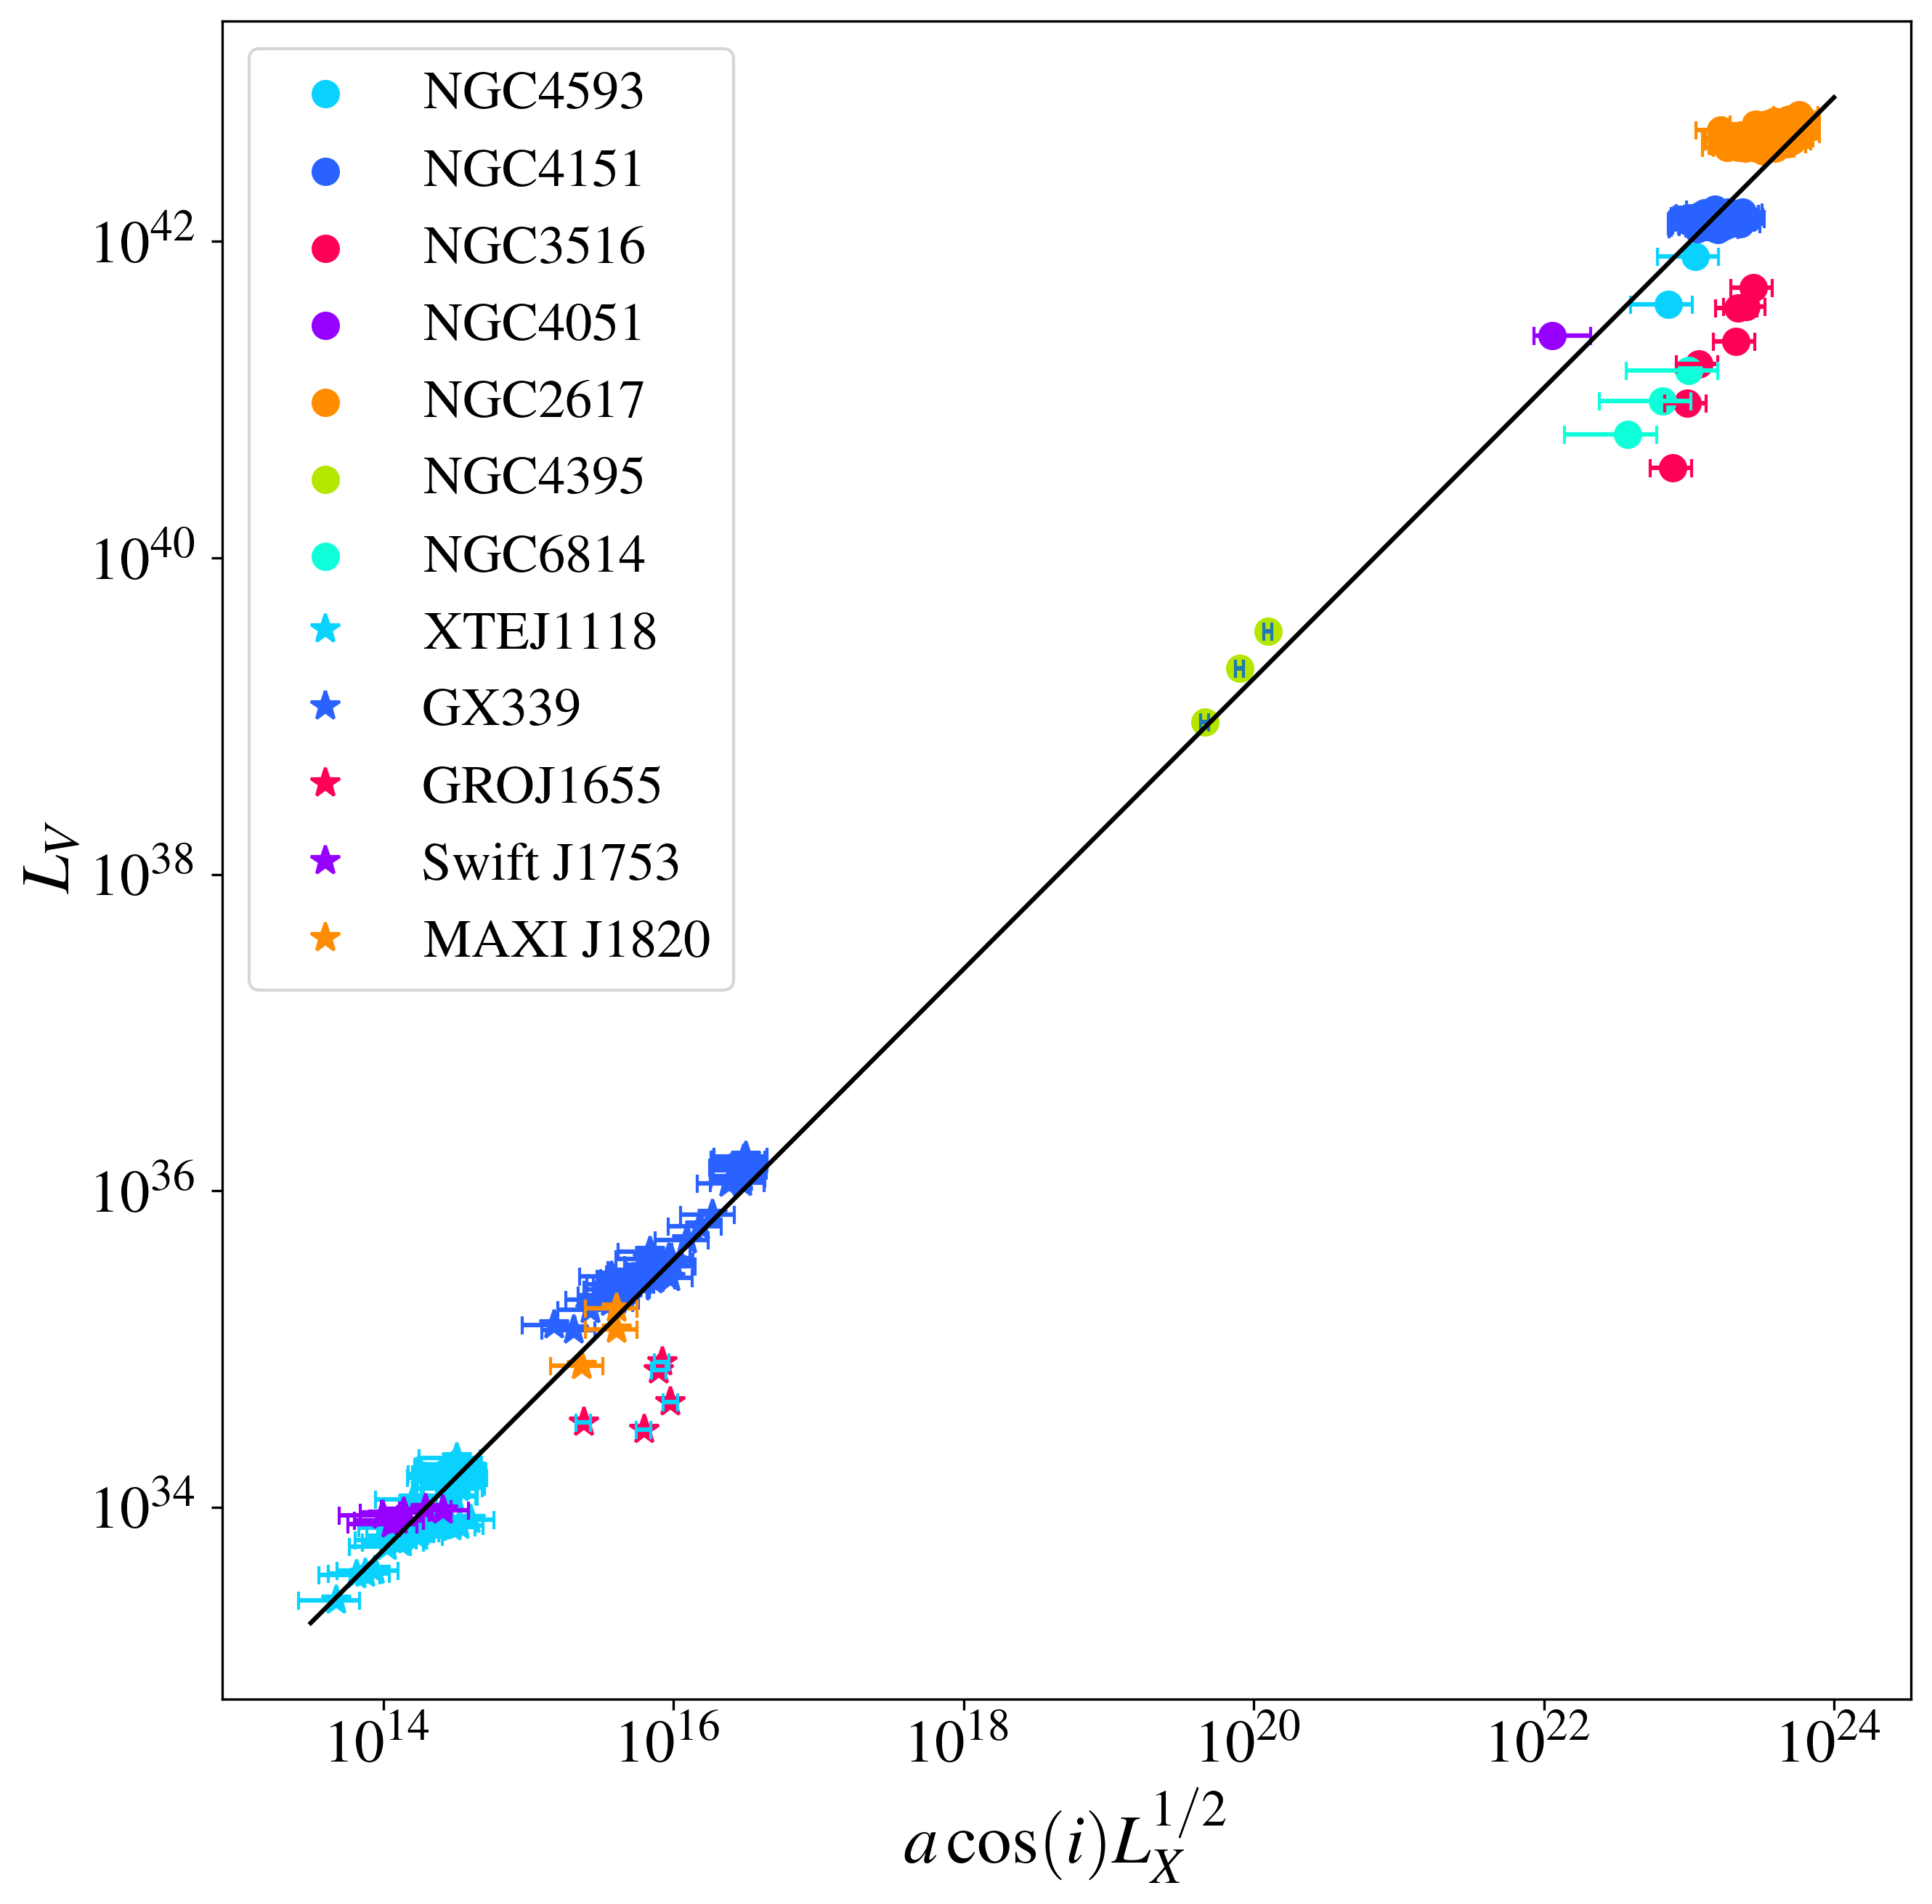

(np.float64(0.9183094869820222), np.float64(20.87140504843394))

In [282]:

# AGN
plt.scatter(n4593["sqrt(L_x) a"] * n4593["cos_i"], n4593["L_opt"], s=70, color=colors[0], label="NGC4593")
plt.errorbar(n4593["sqrt(L_x) a"] * n4593["cos_i"], n4593["L_opt"], xerr=xerr_n4593_cosi, color=colors[0], linestyle='none', capsize=3)

plt.scatter(n4151["sqrt(L_x) a"] * n4151["cos_i"], n4151["L_opt"], s=70, color=colors[1], label="NGC4151")
plt.errorbar(n4151["sqrt(L_x) a"] * n4151["cos_i"], n4151["L_opt"], xerr=xerr_n4151_cosi, color=colors[1], linestyle='none', capsize=3)

plt.scatter(n3516["sqrt(L_x) a"] * n3516["cos_i"], n3516["L_opt"], s=70, color=colors[3], label="NGC3516")
plt.errorbar(n3516["sqrt(L_x) a"] * n3516["cos_i"], n3516["L_opt"], xerr=xerr_n3516_cosi, color=colors[3], linestyle='none', capsize=3)

plt.scatter(n4051["sqrt(L_x) a"] * n4051["cos_i"], n4051["L_opt"], s=70, color=colors[2], label="NGC4051")
plt.errorbar(n4051["sqrt(L_x) a"] * n4051["cos_i"], n4051["L_opt"], xerr=xerr_n4051_cosi, color=colors[2], linestyle='none', capsize=3)

plt.scatter(n2617["sqrt(L_x) a"] * n2617["cos_i"], n2617["L_opt"], s=70, color=colors[4], label="NGC2617")
plt.errorbar(n2617["sqrt(L_x) a"] * n2617["cos_i"], n2617["L_opt"], xerr=xerr_n2617_cosi, color=colors[4], linestyle='none', capsize=3)

plt.scatter(n4395["sqrt(L_x) a"] * n4395["cos_i"], n4395["L_opt"], s=70, color=colors[5], label="NGC4395")
plt.errorbar(n4395["sqrt(L_x) a"] * n4395["cos_i"], n4395["L_opt"], xerr=xerr_n4395_cosi,     linestyle='none', capsize=3)

plt.scatter(n6814["sqrt(L_x) a"] * n6814["cos_i"], n6814["L_opt"], s=70, color=colors[6], label="NGC6814")
plt.errorbar(n6814["sqrt(L_x) a"] * n6814["cos_i"], n6814["L_opt"], xerr=xerr_n6814_cosi,color=colors[6],     linestyle='none', capsize=3)

# XRBs
plt.plot(xtej["sqrt(L_x) a"] * xtej["cos_i"], xtej["L_opt"],  "*",  color=colors[0], markersize=10, label="XTEJ1118")
plt.errorbar(xtej["sqrt(L_x) a"] * xtej["cos_i"], xtej["L_opt"], xerr=xtej["X_err_cosi"] ,color=colors[0],     linestyle='none', capsize=3)

plt.plot(gx["sqrt(L_x) a"] * gx["cos_i"], gx["L_opt"], "*", color=colors[1], markersize=10, label="GX339")
plt.errorbar(gx["sqrt(L_x) a"] * gx["cos_i"], gx["L_opt"], xerr=gx["X_err_cosi"] ,color=colors[1],     linestyle='none', capsize=3)

plt.plot(groj["sqrt(L_x) a"] * groj["cos_i"], groj["L_opt"], "*", color=colors[3], markersize=10, label="GROJ1655")
plt.errorbar(groj["sqrt(L_x) a"] * groj["cos_i"], groj["L_opt"], xerr=groj["X_err_cosi"] ,color=colors[0],     linestyle='none', capsize=3)

plt.plot(j1753["sqrt(L_x) a"] * j1753["cos_i"], j1753["L_opt"], "*", color=colors[2], markersize=10, label="Swift J1753")
plt.errorbar(j1753["sqrt(L_x) a"] * j1753["cos_i"], j1753["L_opt"], xerr=j1753["X_err_cosi"] ,color=colors[2],     linestyle='none', capsize=3)

plt.plot(j1820["sqrt(L_x) a"] * j1820["cos_i"], j1820["L_opt"], "*", color=colors[4], markersize=10, label="MAXI J1820")
plt.errorbar(j1820["sqrt(L_x) a"] * j1820["cos_i"], j1820["L_opt"], xerr=j1820["X_err_cosi"] ,color=colors[4],     linestyle='none', capsize=3)



# info
plt.legend(fontsize=18)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$a\cos(i) L_X^{1/2} $", fontsize=23)
plt.ylabel(r"$L_{V}$", fontsize=23)


# fitting
logA = np.log10(df["sqrt(L_x) a"] * df["cos_i"])
logB = np.log10(df["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(13.5, 24, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


# Increase tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(xfit, function(xfit, a, b), c="black")
plt.show()
a, b  # exactly the same as the excel result

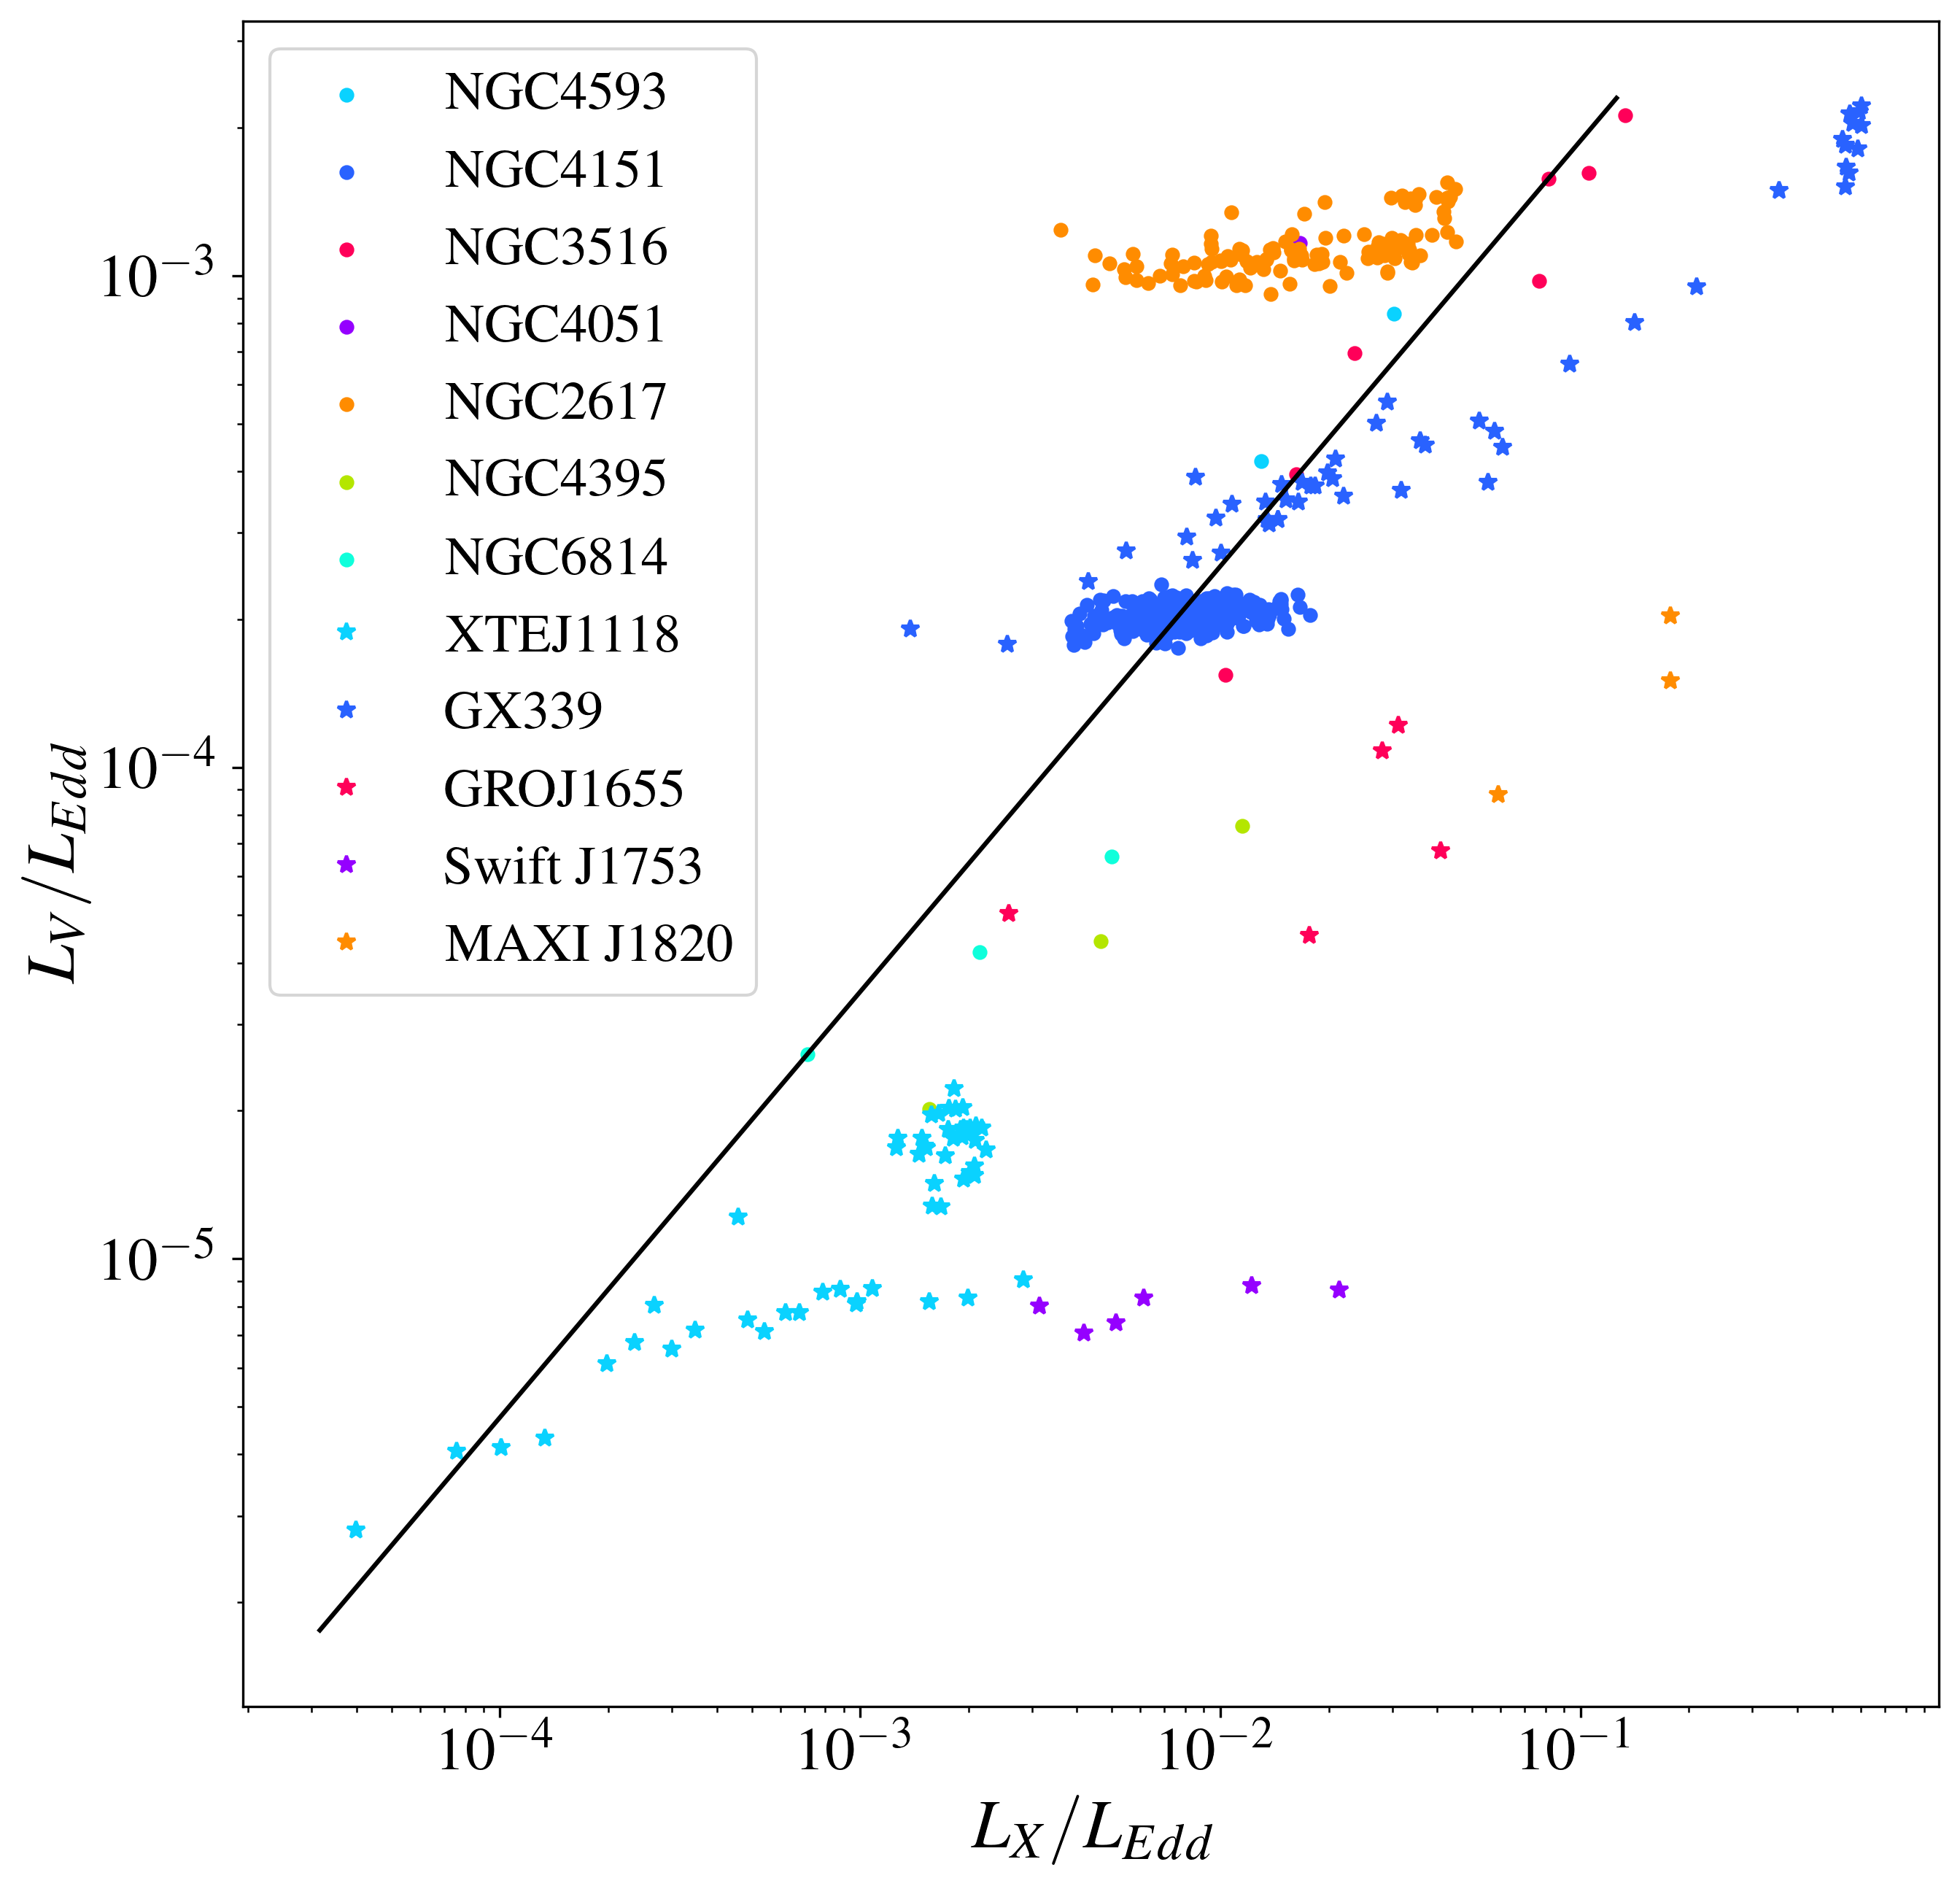

In [309]:
# df = df[df["Target"]!="NGC4151"]
# df = df[df["Target"]!="NGC2617"]
plt.close()
# AGN
plt.scatter(
    n4593["L_x"] / n4593["L_edd"],
    n4593["L_opt"] / n4593["L_edd"],
    s=15,
    c=colors[0],
    label="NGC4593",
)
plt.scatter(
    n4151["L_x"] / n4151["L_edd"],
    n4151["L_opt"] / n4151["L_edd"],
    s=15,
    c=colors[1],
    label="NGC4151",
)
plt.scatter(
    n3516["L_x"] / n3516["L_edd"],
    n3516["L_opt"] / n3516["L_edd"],
    s=15,
    c=colors[3],
    label="NGC3516",
)
plt.scatter(
    n4051["L_x"] / n4051["L_edd"],
    n4051["L_opt"] / n4051["L_edd"],
    s=15,
    c=colors[2],
    label="NGC4051",
)
plt.scatter(
    n2617["L_x"] / n2617["L_edd"],
    n2617["L_opt"] / n2617["L_edd"],
    s=15,
    c=colors[4],
    label="NGC2617",
)
plt.scatter(
    n4395["L_x"] / n4395["L_edd"],
    n4395["L_opt"] / n4395["L_edd"],
    s=15,
    c=colors[5],
    label="NGC4395",
)
plt.scatter(
    n6814["L_x"] / n6814["L_edd"],
    n6814["L_opt"] / n6814["L_edd"],
    s=15,
    c=colors[6],
    label="NGC6814",
)

# XRBs
plt.plot(
    xtej["L_x"] / xtej["L_edd"],
    xtej["L_opt"] / xtej["L_edd"],
    "*",
    c=colors[0],
    label="XTEJ1118",
)
plt.plot(
    gx["L_x"] / gx["L_edd"], gx["L_opt"] / gx["L_edd"], "*", c=colors[1], label="GX339"
)
plt.plot(
    groj["L_x"] / groj["L_edd"],
    groj["L_opt"] / groj["L_edd"],
    "*",
    c=colors[3],
    label="GROJ1655",
)
plt.plot(
    j1753["L_x"] / j1753["L_edd"],
    j1753["L_opt"] / j1753["L_edd"],
    "*",
    c=colors[2],
    label="Swift J1753",
)


plt.plot(j1820["L_x"]/j1820["L_edd"], j1820["L_opt"]/j1820["L_edd"], "*", color=colors[4], label="MAXI J1820")


# info
plt.legend(fontsize=18)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$L_{X}/L_{Edd}$", fontsize=23)
plt.ylabel(r"$L_{V}/L_{Edd}$", fontsize=23)


# fitting
logA = np.log10(df["L_x"] / df["L_edd"])
logB = np.log10(df["L_opt"] / df["L_edd"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(-4.5, -0.9, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


# Increase tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.plot(xfit, function(xfit, a, b), c="black")
plt.savefig(
    "L_Edd.png",
    bbox_inches="tight",
    dpi=300
)

plt.show()
#a, b  # exactly the same as the excel result

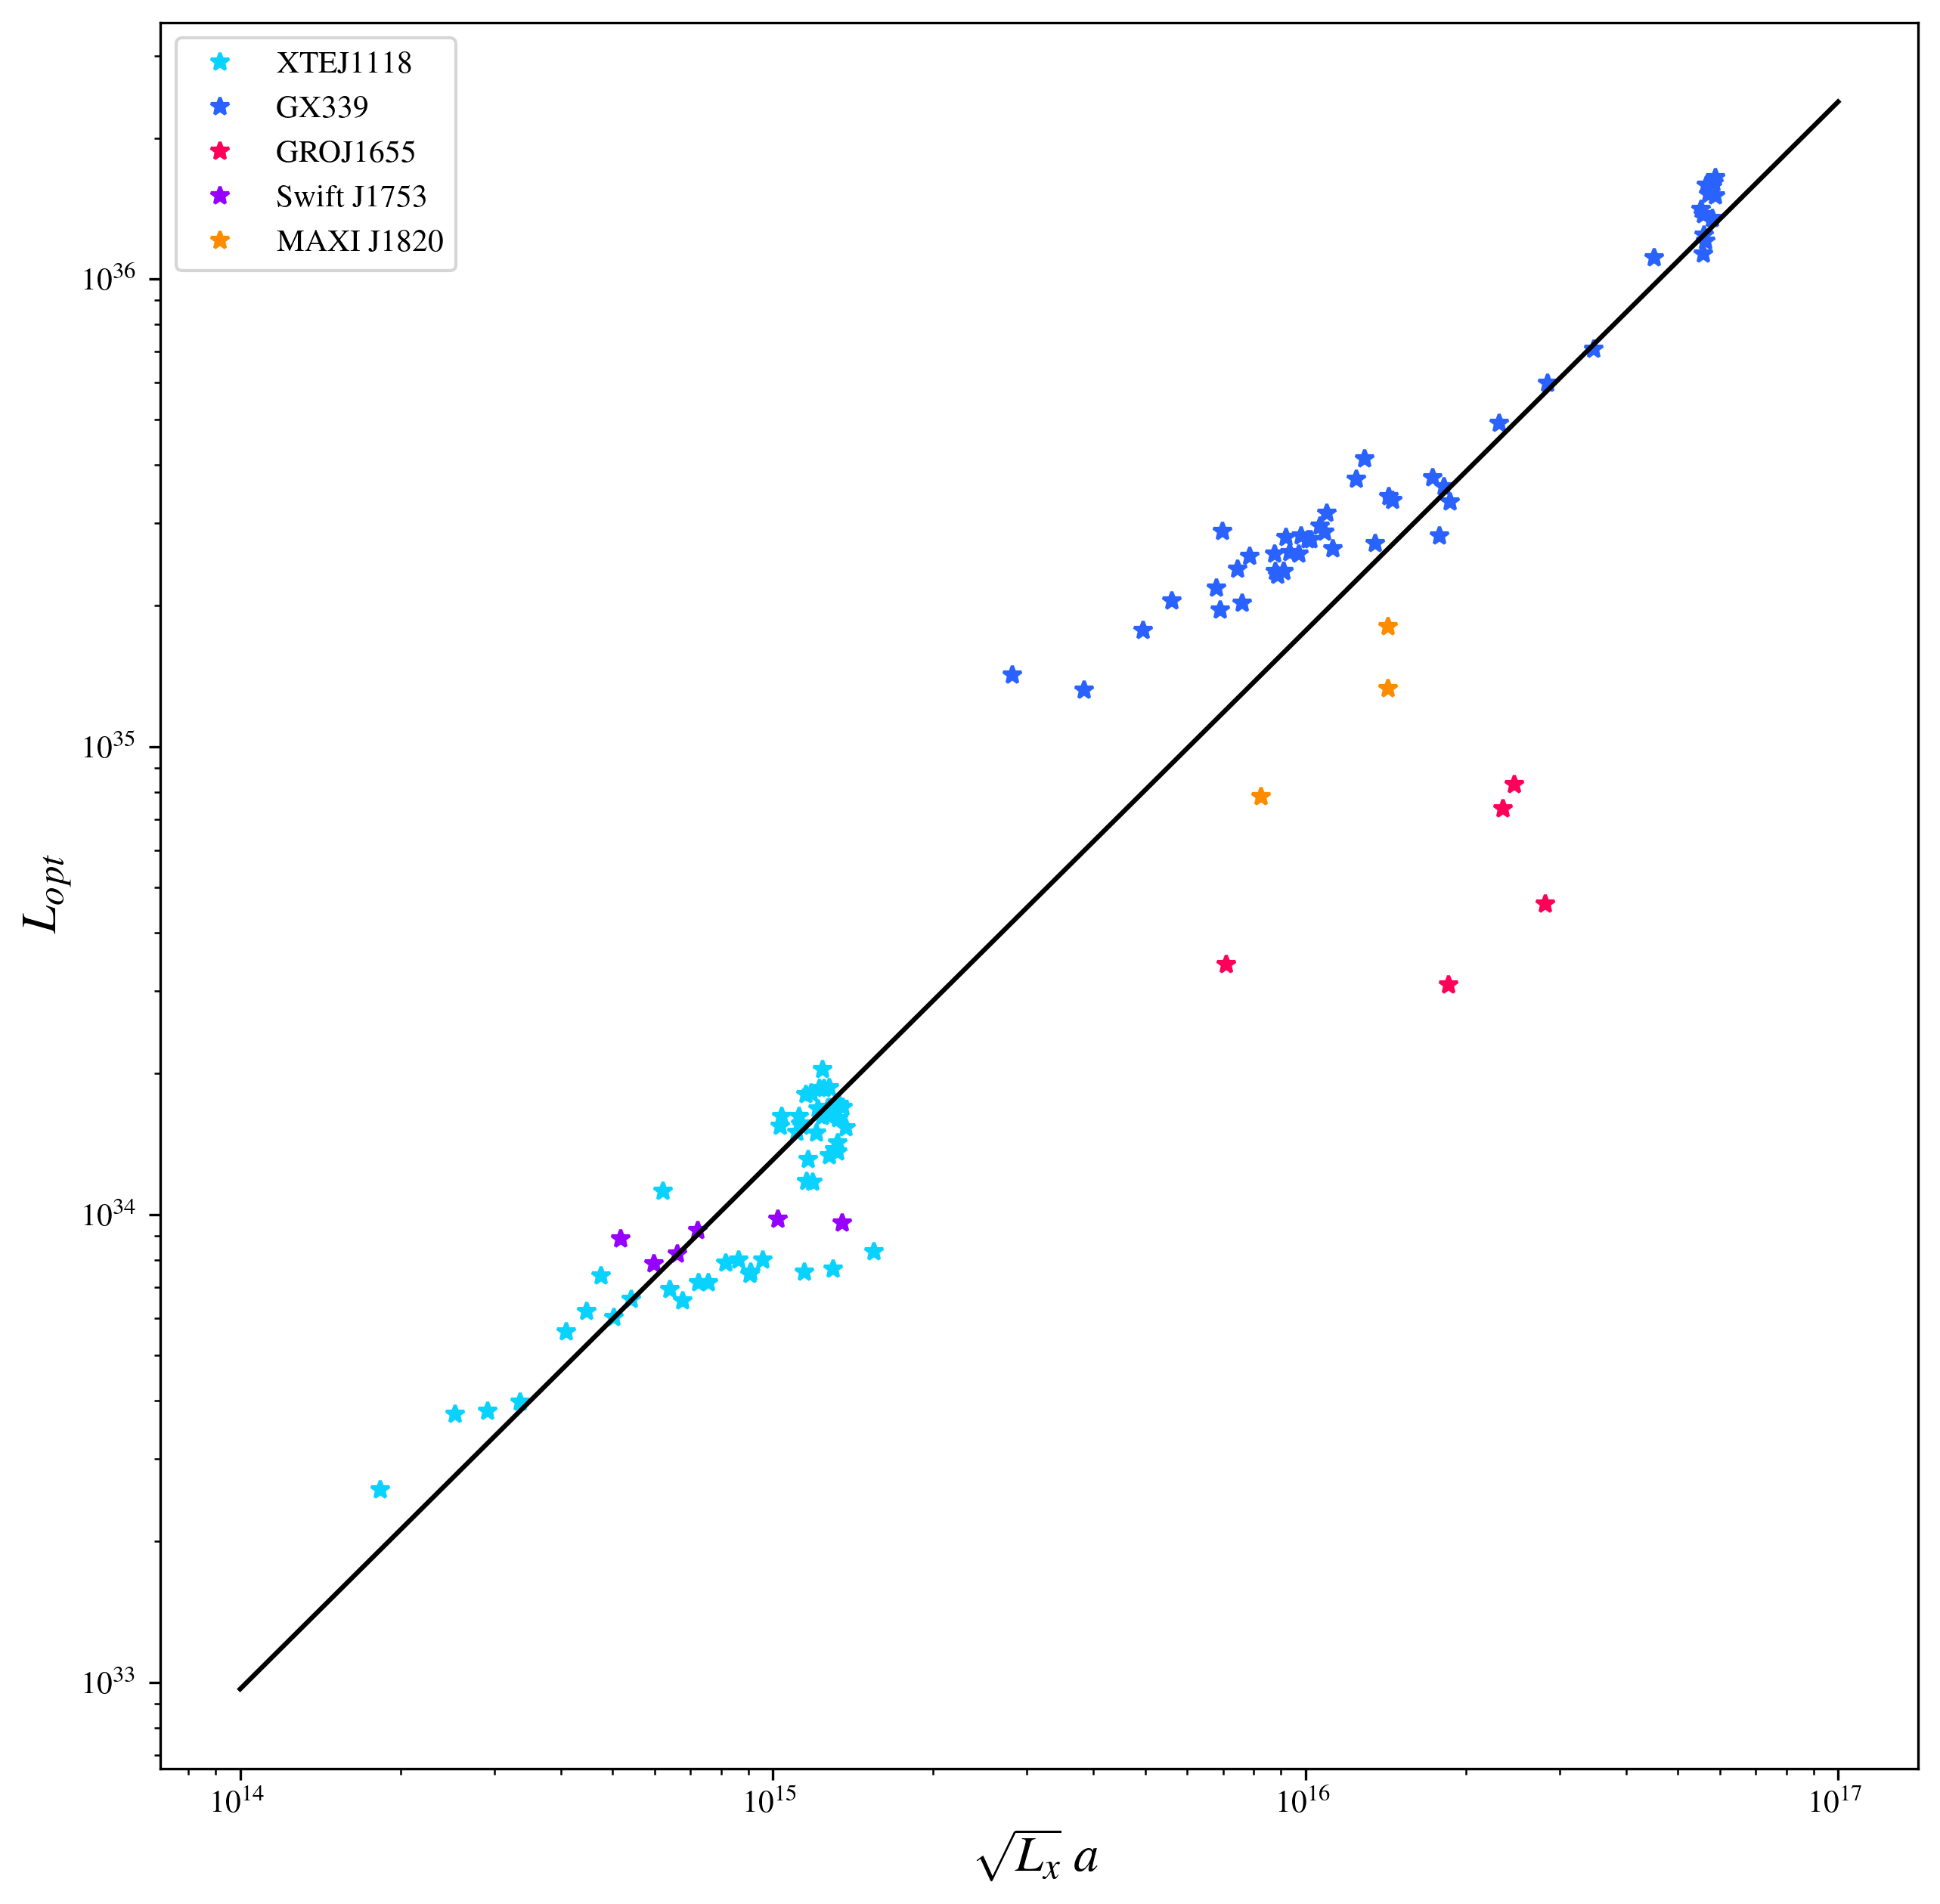

1.1308951658161561 17.153196342098123


,Target,sqrt(L_x) a,L_opt,L_x,cos_i,m_BH,L_edd,Lag_err,X_err,X_err_cosi
0,XTEJ1118,1.129419e+15,1.560553e+34,1.388919e+36,0.258819,7.3,9.198000e+38,0.000431,5.074200e+14,1.313300e+14
1,XTEJ1118,1.182317e+15,1.819897e+34,1.522070e+36,0.258819,7.3,9.198000e+38,0.000431,5.311858e+14,1.374810e+14
2,XTEJ1118,1.216896e+15,1.684312e+34,1.612405e+36,0.258819,7.3,9.198000e+38,0.000431,5.467216e+14,1.415020e+14
3,XTEJ1118,1.206595e+15,1.493065e+34,1.585221e+36,0.258819,7.3,9.198000e+38,0.000431,5.420934e+14,1.403041e+14
4,XTEJ1118,1.239576e+15,1.619118e+34,1.673066e+36,0.258819,7.3,9.198000e+38,0.000431,5.569109e+14,1.441392e+14
...,...,...,...,...,...,...,...,...,...,...
111,J1753,7.233961e+14,9.227027e+33,6.781993e+36,0.190809,8.8,1.108800e+39,0.000139,3.616981e+14,6.901524e+13
112,J1753,5.190140e+14,8.878046e+33,3.491107e+36,0.190809,8.8,1.108800e+39,0.000139,2.595070e+14,4.951627e+13
113,MAXI J1820,8.246140e+15,7.808589e+34,5.242503e+37,0.284015,NaN,8.870400e+38,NaN,3.218006e+15,9.139631e+14
114,MAXI J1820,1.428273e+16,1.329932e+35,1.572751e+38,0.284015,NaN,8.870400e+38,NaN,5.573750e+15,1.583030e+15


In [310]:
df_xrb = pd.concat(
    [
        xtej,
        gx,
        groj,
        j1753,
        j1820,
    ],
    ignore_index=True
)

# AGN
# plt.plot(n4593["sqrt(L_x) a"], n4593["L_opt"], ".", c=colors[0], label="NGC4593")
# plt.plot(n4151["sqrt(L_x) a"], n4151["L_opt"], ".", c=colors[8], label="NGC4151")
# plt.plot(n3516["sqrt(L_x) a"], n3516["L_opt"], ".", c=colors[5], label="NGC3516")
# plt.plot(n4051["sqrt(L_x) a"], n4051["L_opt"], ".", c=colors[15], label="NGC4051")
# plt.plot(n2617["sqrt(L_x) a"], n2617["L_opt"], ".", c=colors[3], label="NGC2617")
# plt.plot(n4395["sqrt(L_x) a"], n4395["L_opt"], ".", c=colors[10], label="NGC4395")
# plt.plot(n6814["sqrt(L_x) a"], n6814["L_opt"], ".", c=colors[13], label="NGC6814")

# XRBs
plt.plot(xtej["sqrt(L_x) a"], xtej["L_opt"], "*", c=colors[0], label="XTEJ1118")
plt.plot(gx["sqrt(L_x) a"], gx["L_opt"], "*", c=colors[1], label="GX339")
plt.plot(groj["sqrt(L_x) a"], groj["L_opt"], "*", c=colors[3], label="GROJ1655")
plt.plot(j1753["sqrt(L_x) a"], j1753["L_opt"], "*", c=colors[2], label="Swift J1753")
plt.plot(j1820["sqrt(L_x) a"], j1820["L_opt"], "*", c=colors[4], label="MAXI J1820")


# info
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\sqrt{L_x} \ a$", fontsize=16)
plt.ylabel(r"$L_{opt}$", fontsize=16)

# fitting
logA = np.log10(df_xrb["sqrt(L_x) a"])
logB = np.log10(df_xrb["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(14, 17, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


plt.plot(xfit, function(xfit, a, b), c="black")
plt.savefig(
    "XRB_only.png",
    bbox_inches="tight",
    dpi=300
)
plt.show()
print(a, b)  # exactly the same as the excel result
df_xrb


In [300]:
df_agn = pd.concat(
    [
        n4593,
        n4151,
        n3516,
        n4051,
        n2617,
        n4395,
        n6814,
    ],
    ignore_index=True
)
df_agn

,Target,sqrt(L_x) a,L_opt,L_x,cos_i,L_edd
0,NGC4593,1.175452e+23,8.055198e+41,2.915903e+43,0.939693,9.613800e+44
1,NGC4593,7.695143e+22,4.027599e+41,1.249673e+43,0.939693,9.613800e+44
2,NGC4151,1.953186e+23,1.308391e+42,3.919023e+43,0.707107,6.804000e+45
3,NGC4151,2.100993e+23,1.254582e+42,4.534609e+43,0.707107,6.804000e+45
4,NGC4151,2.356237e+23,1.384648e+42,5.703334e+43,0.707107,6.804000e+45
...,...,...,...,...,...,...
431,NGC4395,1.006329e+20,2.007882e+39,2.113649e+41,0.798636,4.536000e+43
432,NGC4395,5.810046e+19,9.159351e+38,7.045497e+40,0.798636,4.536000e+43
433,NGC6814,1.556436e+23,1.534196e+41,1.165019e+43,0.642788,2.331000e+45
434,NGC6814,1.018927e+23,9.811758e+40,4.992939e+42,0.642788,2.331000e+45


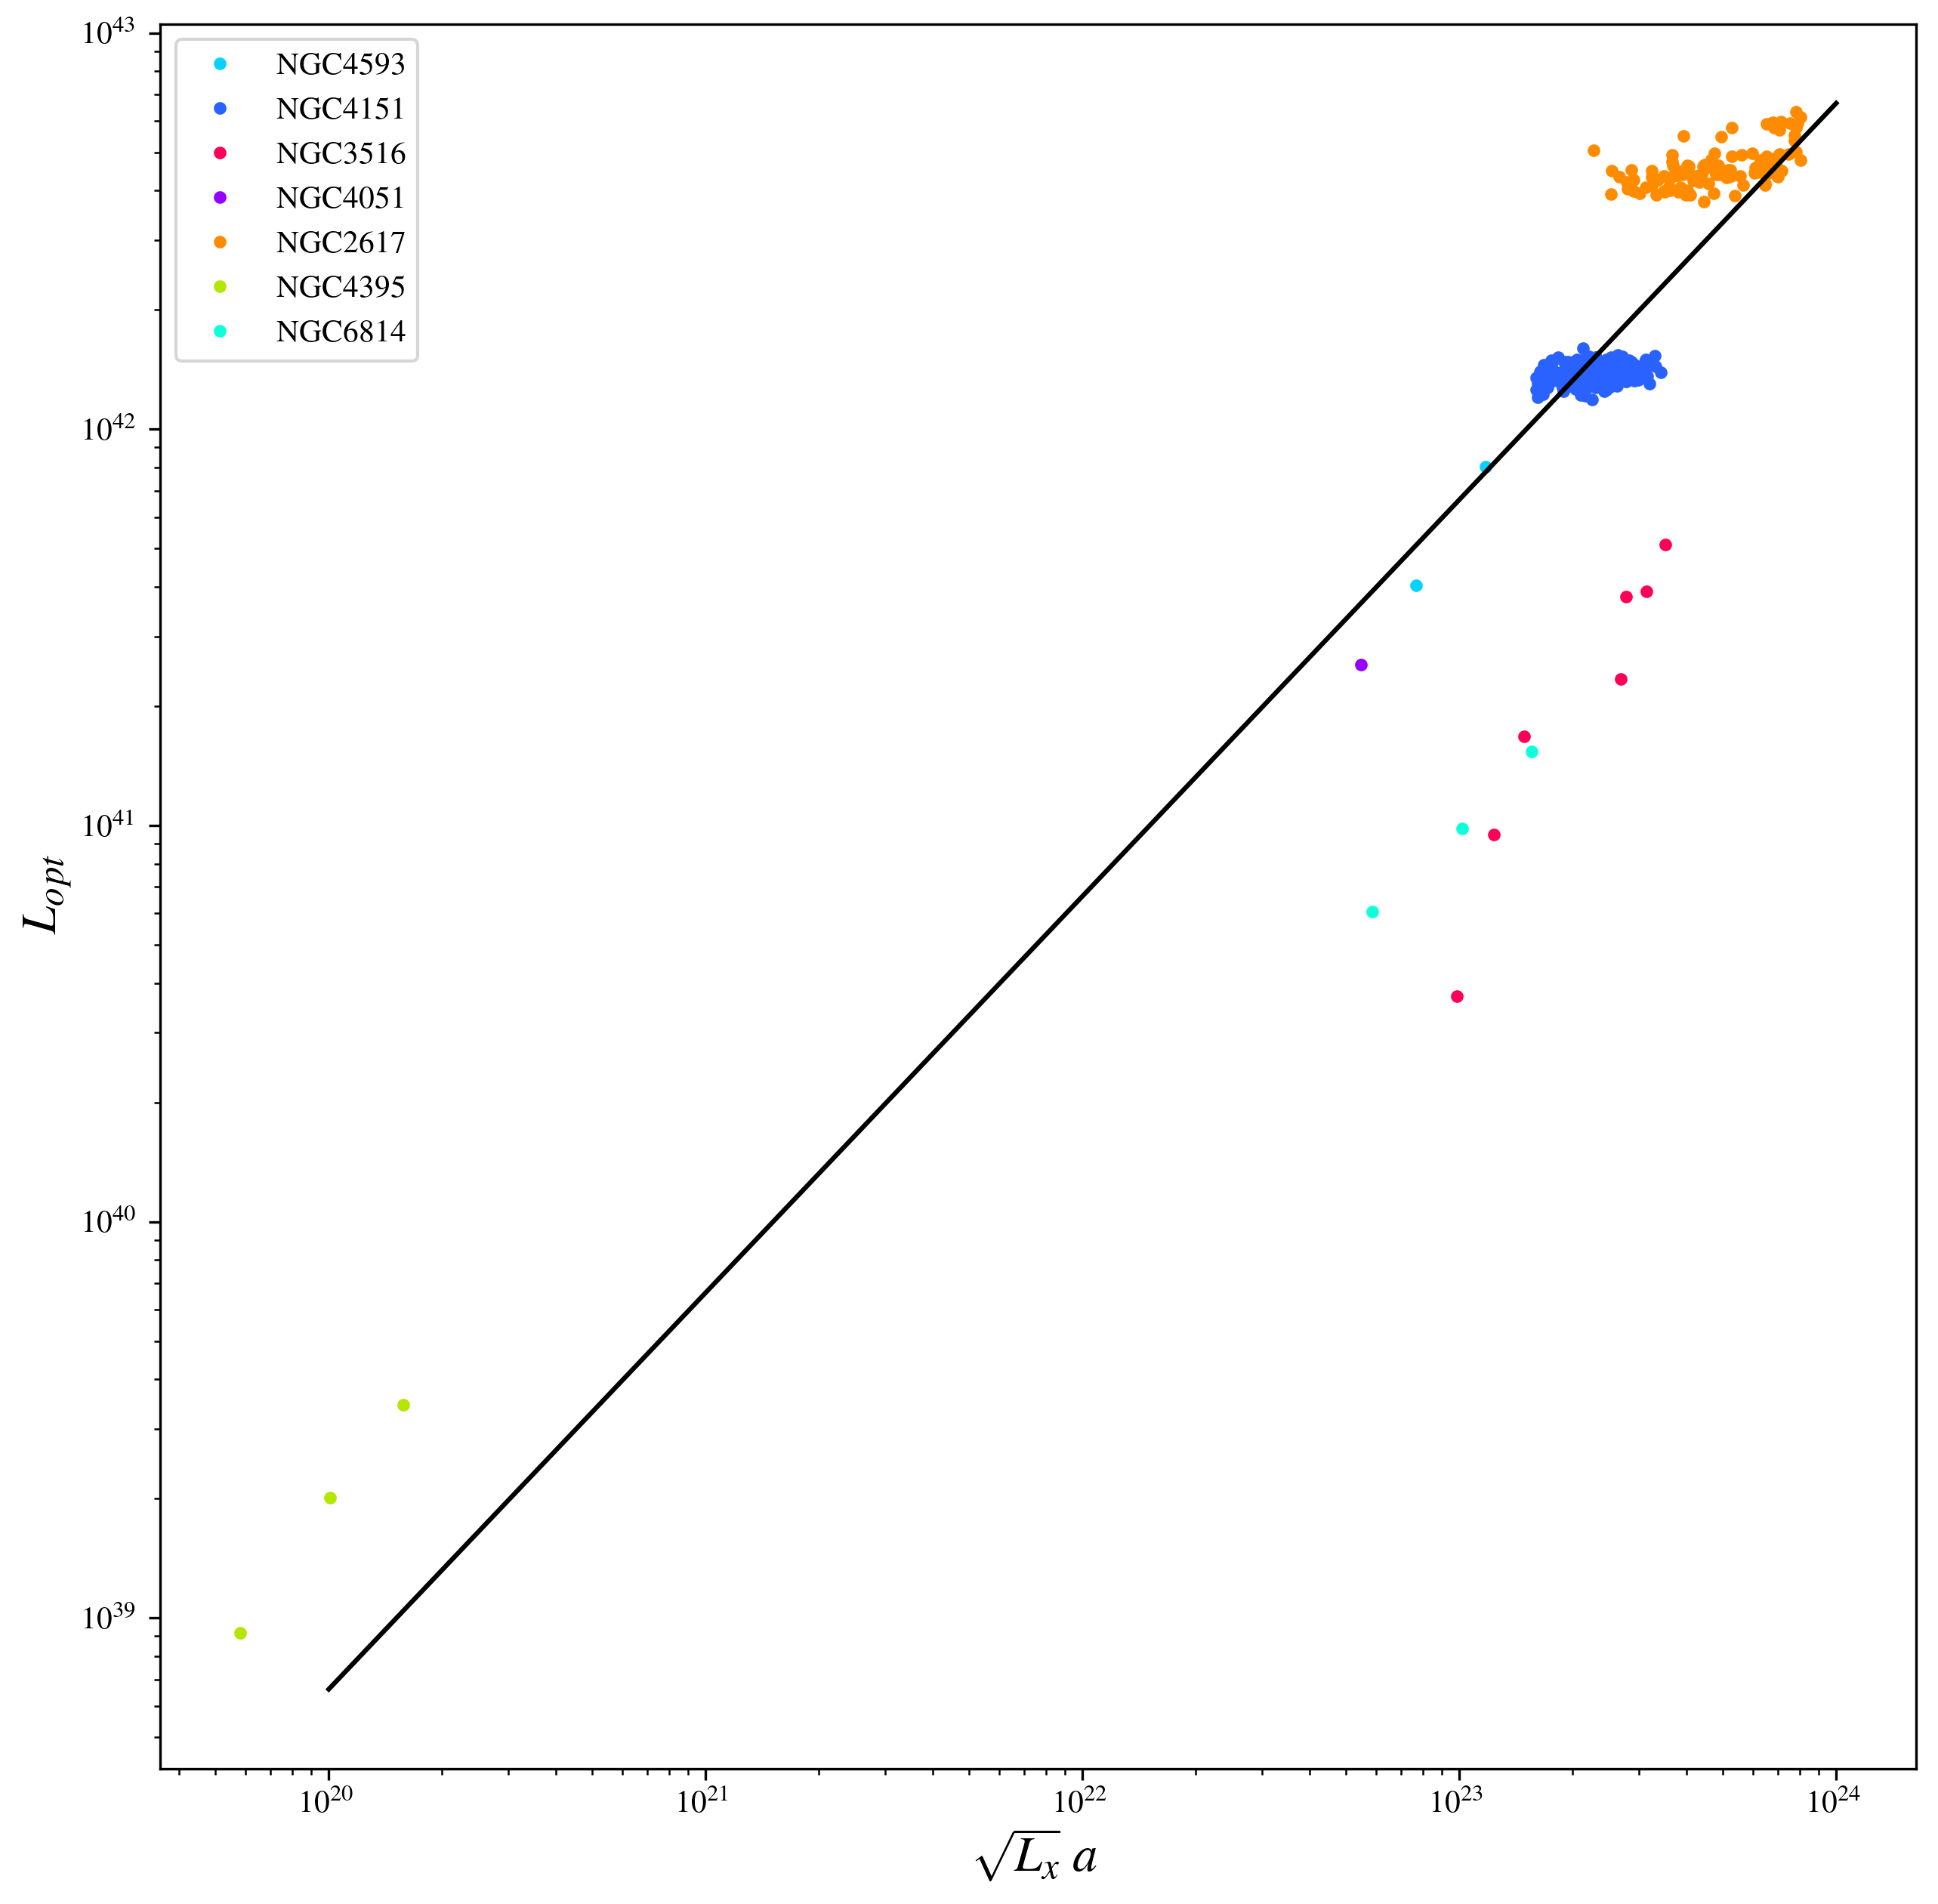

(np.float64(1.0005943638951245), np.float64(18.808393979258632))

In [311]:
# AGN
plt.plot(n4593["sqrt(L_x) a"], n4593["L_opt"], ".", c=colors[0], label="NGC4593")
plt.plot(n4151["sqrt(L_x) a"], n4151["L_opt"], ".", c=colors[1], label="NGC4151")
plt.plot(n3516["sqrt(L_x) a"], n3516["L_opt"], ".", c=colors[3], label="NGC3516")
plt.plot(n4051["sqrt(L_x) a"], n4051["L_opt"], ".", c=colors[2], label="NGC4051")
plt.plot(n2617["sqrt(L_x) a"], n2617["L_opt"], ".", c=colors[4], label="NGC2617")
plt.plot(n4395["sqrt(L_x) a"], n4395["L_opt"], ".", c=colors[5], label="NGC4395")
plt.plot(n6814["sqrt(L_x) a"], n6814["L_opt"], ".", c=colors[6], label="NGC6814")
# XRBs
# plt.plot(xtej['sqrt(L_x) a'], xtej['L_opt'],   '.', c=colors[2], label='XTEJ1118')
# plt.plot(gx['sqrt(L_x) a'], gx['L_opt'],       '.', c=colors[1], label='GX339')
# plt.plot(groj['sqrt(L_x) a'], groj['L_opt'],   '.', c=colors[0], label='GROJ1655')


# info
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\sqrt{L_x} \ a$", fontsize=16)
plt.ylabel(r"$L_{opt}$", fontsize=16)

df_filtered = df_agn

# fitting
logA = np.log10(df_filtered["sqrt(L_x) a"])
logB = np.log10(df_filtered["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(20, 24, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


plt.plot(xfit, function(xfit, a, b), c="black")

plt.savefig(
    "AGN_only.png",
    bbox_inches="tight",
    dpi=300
)

plt.show()
a, b  # exactly the same as the excel result

## Another Correlation

In [149]:
f = pd.read_csv("/Users/avm4/work/GitHub/astrophysics/agn-xrb/data/lag-size.csv")
# f = f[f['Source']!='Cyg X-2']

f

FileNotFoundError: [Errno 2] No such file or directory: '/Users/avm4/work/GitHub/astrophysics/agn-xrb/data/lag-size.csv'

In [ ]:
f = f[f["Source"] != "Cyg X-2"]
f = f[f["type"] == "BH LMXB"]
f

### New Analysis

#### Objectives
- Plot the data
- Plot the error bar
- Put the linear fitting function and check

In [ ]:
f = f[f["Source"] != "Cyg X-2"]
f
x = np.array(f["disc.radius(ls)"])
y = np.array(f["optical lag (s)"])
yerr = np.array(f["+-"])
labels = np.array(f["Source"])

In [ ]:
for i in range(len(x)):
    # print(f['Source'][i])
    plt.errorbar(x[i], y[i], yerr=yerr[i], label=labels[i], capsize=5, fmt="o")

xfit = np.logspace(0.5, 1.65, 100)  # 2.1


def func(x, a, b):
    return 10 ** (b) * x ** (a)


popt, pcov = curve_fit(func, x, y)
print(popt)
plt.plot(
    xfit, func(xfit, *popt), "-", color="black"
)  # label="fit: a=%5.3f, b=%5.3f" % tuple(popt))

# Increase tick sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# info
plt.legend(fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Disk Radius (ls)", fontsize=20)
plt.ylabel("Optical lag (s)", fontsize=20)

### Previous Code (Non-linear Regression)

In [150]:
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=None, data=f)
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", data=f, hue="Source")

NameError: name 'sns' is not defined

In [151]:
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", c="b", data=f, hue="Source")
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=95, data=f)
x = f["disc.radius(ls)"]
dy = f["+-"]
y = f["optical lag (s)"]
plt.errorbar(x, y, yerr=dy, c="black", fmt="none", elinewidth=1, capsize=2)

NameError: name 'sns' is not defined

### Without Cyg X-2

In [152]:
# without Cyg X-2
f = f[f["Source"] != "Cyg X-2"]
f

NameError: name 'f' is not defined

In [153]:
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=None, data=f)
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", data=f, hue="Source")
plt.xscale("log")


plt.yscale("log")

NameError: name 'sns' is not defined

In [154]:
x = f["disc.radius(ls)"]
dy = f["+-"]
y = f["optical lag (s)"]
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", c="b", data=f, hue="Source")
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=95, data=f)

plt.errorbar(x, y, yerr=dy, c="black", fmt="none", elinewidth=1, capsize=2)
plt.xscale("log")
plt.yscale("log")

NameError: name 'f' is not defined